<a href="https://colab.research.google.com/github/nickykantaphon/cis545-project/blob/main/CIS_545_Final_Notebook_Credit_Card_Approval_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CIS 545 Final Project: Credit Card Approval Prediction**


# **1. Introduction**


Credit score is a prevalent method to control risks in the financial industry. By utilizing personal information and applicant data, we are able to predict the possibility of defaulting from credit card borrowings. Machine learning algorithms can come into play to help financial institutions decide whether the applicants have good or bad credit, in order to make a judgement about credit card approval. Many banks offer approval decisions for credit cards immediately after applications have been filled. If any financial institutions had an accurate model to predict applicants’ credit behaviors, they would be able to reduce risks of defaulting while saving costs, since manually analyzing applications is both time-consuming and error-prone.

Through this project, we will be able to understand first-hand how financial institutions use historical and personal data to build a model that helps determine whether new applicants have good or bad credit.

We will work with [Credit Card Dataset for Machine Learning](https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction) from Kaggle. Our data includes 2 tables that are linked by ID: (1) `application_record.csv` containing applicants’ personal information, which can be used as features to run predictive models, and (2) `credit_record.csv` recording user behaviors of credit cards, which can be used as an output or dependent variable to determine whether the users should have good or bad credit.

Our goal ultimately is to develop the model to perform binary classification: determining whether, given a set of input or independent variables, this specific applicant has a good or bad credit. We would also conduct exploratory data analysis (EDA) to find interesting trends or correlations in the dataset as well as visualizing the data to gain more insights into the datasets.

We will utilize supervised machine learning algorithms, such as Logistic Regression and Random Forest, to train our model to perform binary classification, i.e., predicting whether a certain customer would have good or bad credit behavior.




In [ ]:
# Library Setup
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from matplotlib import cm
from google.colab import drive
from google.colab import files
from string import ascii_letters
from lxml import html
! pip install kaggle

In [ ]:
# Upload API file (kaggle.json)
files.upload() 

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nickywongchamcharoen","key":"4dab17e9341232e271ace6a32c6302db"}'}

In [ ]:
# Download datasets from Kaggle
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download rikdifos/credit-card-approval-prediction
! unzip /content/credit-card-approval-prediction.zip

  0% 0.00/5.32M [00:00<?, ?B/s]
100% 5.32M/5.32M [00:00<00:00, 122MB/s]
Archive:  /content/credit-card-approval-prediction.zip
  inflating: application_record.csv  
  inflating: credit_record.csv       


In [ ]:
# Read dataset into Pandas Dataframes
application_df = pd.read_csv('application_record.csv')
credit_df = pd.read_csv('credit_record.csv')
pd.set_option('display.max_columns', 100)

# **2. Exploratory Data Analysis (EDA)**
- Exploratory Data Analysis (EDA) is an analyzing approach that summarizes the main characteristics of a given dataset.
- Our dataframes include:
1. `application_df`: containing applicants’ personal information
2. `credit_df`: recording users' credit card payment behavior each month

These two dataframes are linked through `'ID'` column.

## 2.1 Data Cleaning
First, we will visualize our dataframes to see how our data look like.

In [ ]:
application_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [ ]:
credit_df.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


**Unique IDs**


In [ ]:
# application_df
print(f"Number of rows for application records: {len(application_df)}")
print(f"Number of unique IDs in the dataset: {len(application_df['ID'].unique())}")

Number of rows for application records: 438557
Number of unique IDs in the dataset: 438510


In [ ]:
# credit_df
print(f"Number of rows for credit records: {len(credit_df)}")
print(f"Number of unique IDs in the dataset: {len(credit_df['ID'].unique())}")

Number of rows for credit records: 1048575
Number of unique IDs in the dataset: 45985


In [ ]:
# Intersection of client IDs in both datasets
print(f"Number of IDs in both application and credit datasets: {len(set(application_df['ID']).intersection(set(credit_df['ID'])))}")

Number of IDs in both application and credit datasets: 36457


Upon inspection, we can see the number of unique `'ID'`'s in `credit_df` is a lot fewer than that in `application_df`. Once we find the intersection of both datasets through `ID`, we can estimate the size of data that can be used for our model.

**Missing Values**

In [ ]:
credit_df.isnull().sum()

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [ ]:
application_df.isnull().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

Text(0.5, 1.0, 'Missing Values of application_df')

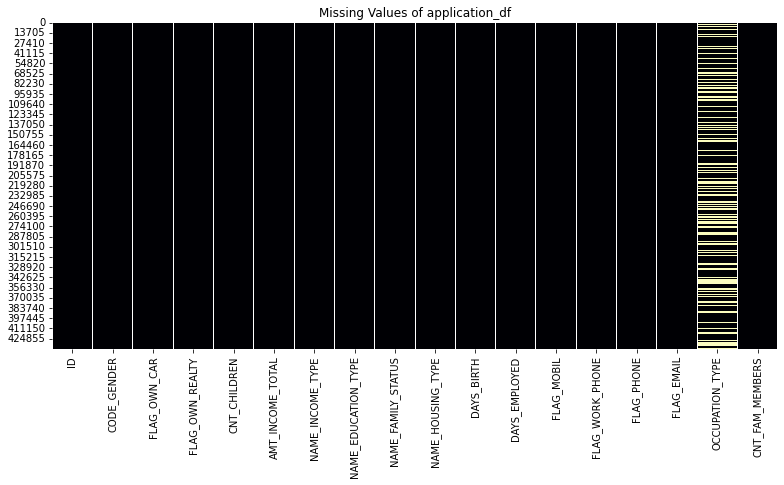

In [ ]:
# Visualizing missing values
plt.figure(figsize=(13,6))
sns.heatmap(application_df.isnull(), cmap='magma', cbar=False)
plt.title('Missing Values of application_df')

Upon inspection, we can see that `credit_df` has no missing values. Meanwhile in `application_df`, almost 1/3 of `'OCCUPATION_TYPE'` are missing. Because a significant portion of the dataset is missing `'OCCUPATION_TYPE'`, it is not feasible to drop rows with a missing value. Instead, we will fill in the nan in `'OCCUPATION_TYPE'` with `'Other'`.

**Duplicate Values**

In [ ]:
application_df.duplicated().value_counts()
# No duplicate values in application_df

False    438557
dtype: int64

In [ ]:
credit_df.duplicated().value_counts()
# No duplicate values in credit_df

False    1048575
dtype: int64

Upon inspection, we can see that our data has no duplicated values.

**Unique Values in Each Column**

In [ ]:
application_df.nunique()

ID                     438510
CODE_GENDER                 2
FLAG_OWN_CAR                2
FLAG_OWN_REALTY             2
CNT_CHILDREN               12
AMT_INCOME_TOTAL          866
NAME_INCOME_TYPE            5
NAME_EDUCATION_TYPE         5
NAME_FAMILY_STATUS          5
NAME_HOUSING_TYPE           6
DAYS_BIRTH              16379
DAYS_EMPLOYED            9406
FLAG_MOBIL                  1
FLAG_WORK_PHONE             2
FLAG_PHONE                  2
FLAG_EMAIL                  2
OCCUPATION_TYPE            18
CNT_FAM_MEMBERS            13
dtype: int64

Note that `'FLAG_MOBIL'` has the same value across all rows, so we will drop this column.


In [ ]:
application_df = application_df.drop(columns=['FLAG_MOBIL'])

In [ ]:
credit_df.nunique()

ID                45985
MONTHS_BALANCE       61
STATUS                8
dtype: int64

Observation:
- From the number of unique values in each column along with the description of the column in the documentation, we gained more insights into the classes divided by one feature. For example, there are a lot of binary classes in our dataset. There are also some continuous numerical data such as `DAYS_BIRTH` and `DAYS_EMPLOYED` which require conversion later on.
- We can see that there are 19 occupation types. Since one-hot encoding tends to create too many predictors when there are many unique values in the original column, thus it might not be a great idea to apply one-hot encoding on the column. On the other hand, label encoding assumes the ranking between classes in the feature. However, occupation has no hieracical relationship between each other, so label encoding might not be optimal either. Thus, we would not include occupation type as one of the feature. 
- It would be reasonable to drop occupation types, since from our domain knowledge, the income feature is somewhat correlated to occupation types. Income is also an important factor that financial institutions evaluates when assessing credit card applications.

## **2.2 Data Visualization: Before Feature-Engineering Target Variables**
Since we do not have target variables in our `application_df` yet, we will visualize our data without target variables. Then, we will revisit the visualization after feature engineering.

**Visualization of `application_df`**

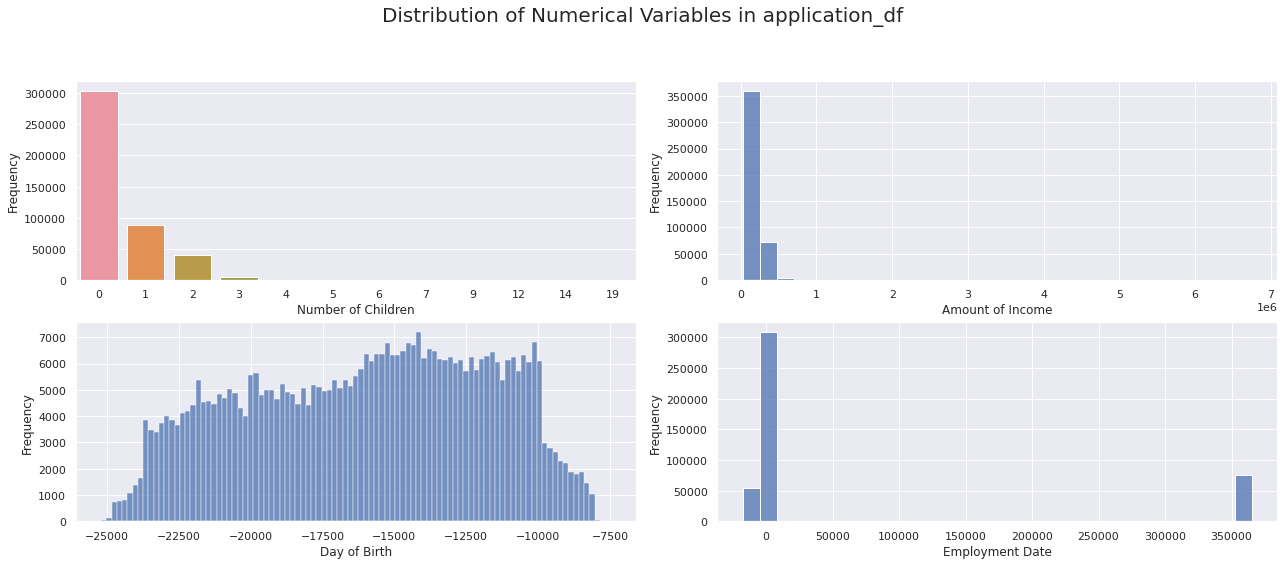

In [ ]:
%matplotlib inline
sns.set_theme()

# Distribution of numerical variables
fig, ax = plt.subplots(2, 2, figsize=(18, 8))
fig.suptitle('Distribution of Numerical Variables in application_df', fontsize=20)

sns.countplot(ax=ax[0,0], data = application_df, x = 'CNT_CHILDREN')
ax[0,0].set_xlabel('Number of Children')
ax[0,0].set_ylabel('Frequency')

sns.histplot(ax=ax[0,1], data = application_df, x = 'AMT_INCOME_TOTAL', bins=30)
ax[0,1].set_xlabel('Amount of Income')
ax[0,1].set_ylabel('Frequency')

sns.histplot(ax=ax[1,0], data = application_df, x = 'DAYS_BIRTH')
ax[1, 0].set_xlabel('Day of Birth')
ax[1, 0].set_ylabel('Frequency')

sns.histplot(ax=ax[1,1], data = application_df, x = 'DAYS_EMPLOYED', bins=30)
ax[1, 1].set_xlabel('Employment Date')
ax[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.subplots_adjust(top=0.85)

Observation:
- There are outliers in 'Number of Children' and 'Amount of Income,' and both columns are right-skewed.
- The 'Day of Birth' and 'Employment Date' data are not that helpful in this form. Therefore, we will convert them to 'Age', 'Employment Status', and 'Employment Period' later on.

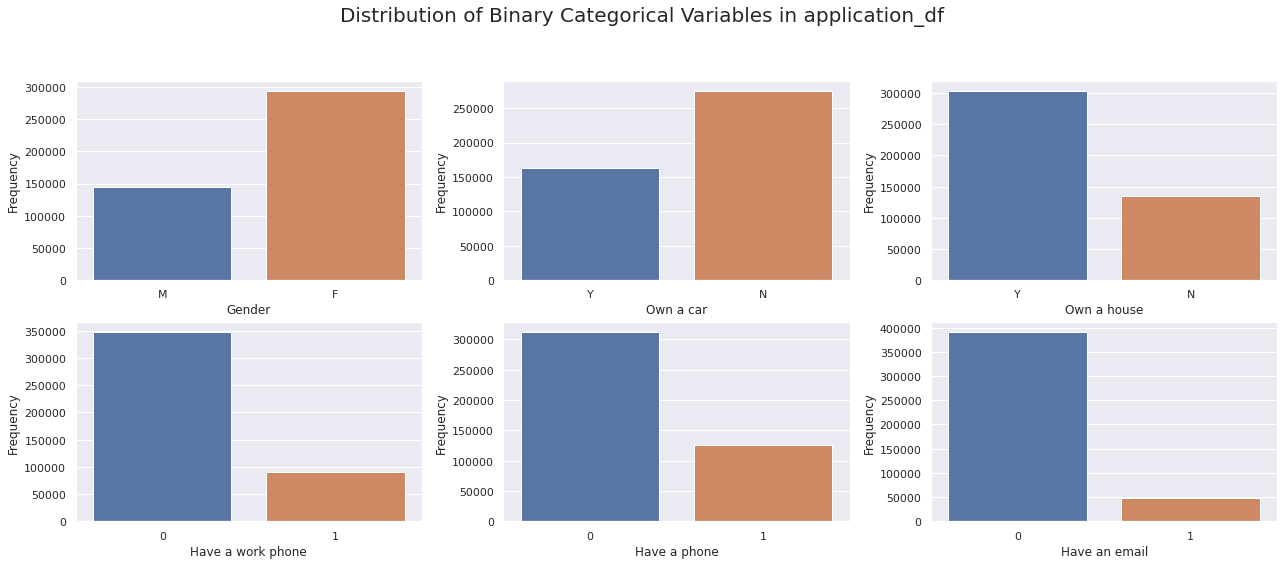

In [ ]:
# Distribution of binary categorical variables

fig, ax = plt.subplots(2, 3, figsize=(18, 8))
fig.suptitle('Distribution of Binary Categorical Variables in application_df', fontsize=20)

sns.countplot(ax=ax[0,0], data = application_df, x = 'CODE_GENDER')
ax[0,0].set_xlabel('Gender')
ax[0,0].set_ylabel('Frequency')

sns.countplot(ax=ax[0,1], data = application_df, x = 'FLAG_OWN_CAR')
ax[0,1].set_xlabel('Own a car')
ax[0,1].set_ylabel('Frequency')

sns.countplot(ax=ax[0,2], data = application_df, x = 'FLAG_OWN_REALTY')
ax[0,2].set_xlabel('Own a house')
ax[0,2].set_ylabel('Frequency')

sns.countplot(ax=ax[1,0], data = application_df, x = 'FLAG_WORK_PHONE')
ax[1,0].set_xlabel('Have a work phone')
ax[1,0].set_ylabel('Frequency')

sns.countplot(ax=ax[1,1], data = application_df, x = 'FLAG_PHONE')
ax[1,1].set_xlabel('Have a phone')
ax[1,1].set_ylabel('Frequency')

sns.countplot(ax=ax[1,2], data = application_df, x = 'FLAG_EMAIL')
ax[1,2].set_xlabel('Have an email')
ax[1,2].set_ylabel('Frequency')

plt.tight_layout()
plt.subplots_adjust(top=0.85)

Observation:
- The binary categorical data in our dataset are quite imbalanced, which might affect our model performance.
- Most specifically, we can see that having an email is the most imbalanced. If this leads to imbalanced target classes, the model would predict the majortiy class, rather than learning anything. The accuracy would also be artificially high.

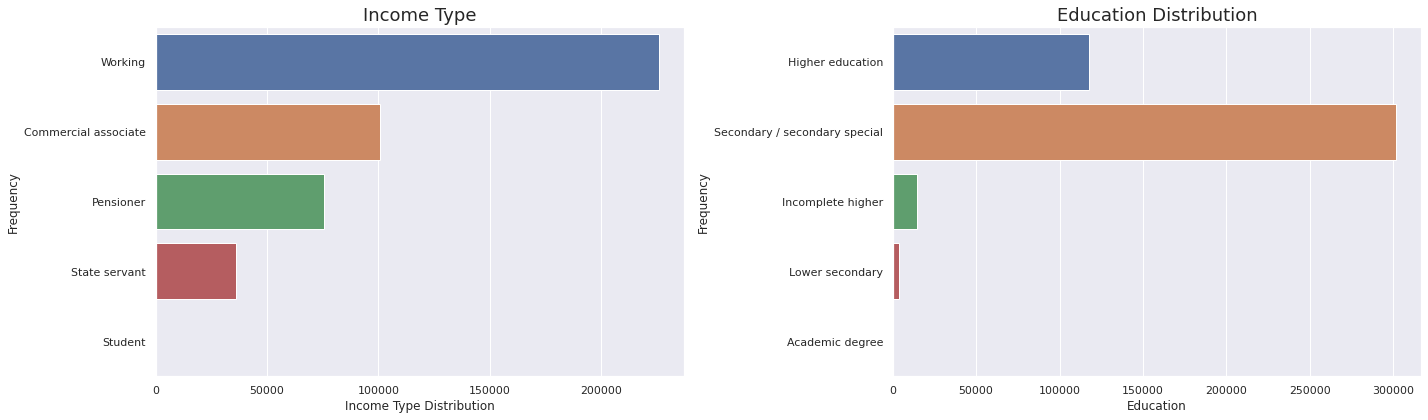

In [ ]:
# Distribution of Other categorial variables in application_df
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sns.countplot(ax=ax[0], data = application_df, y = 'NAME_INCOME_TYPE')
ax[0].set_xlabel('Income Type Distribution')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Income Type', fontsize=18)

sns.countplot(ax=ax[1], data = application_df, y = 'NAME_EDUCATION_TYPE')
ax[1].set_xlabel('Education')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Education Distribution', fontsize=18)


plt.tight_layout()

Observation:
- The majority class in 'Income Type' is Working, which is a very broad term. It is unclear why Commercial Associate has a different column.
- The biggest class in 'Education Type' is Secondary/secondary special, and then 'Higher education.' 

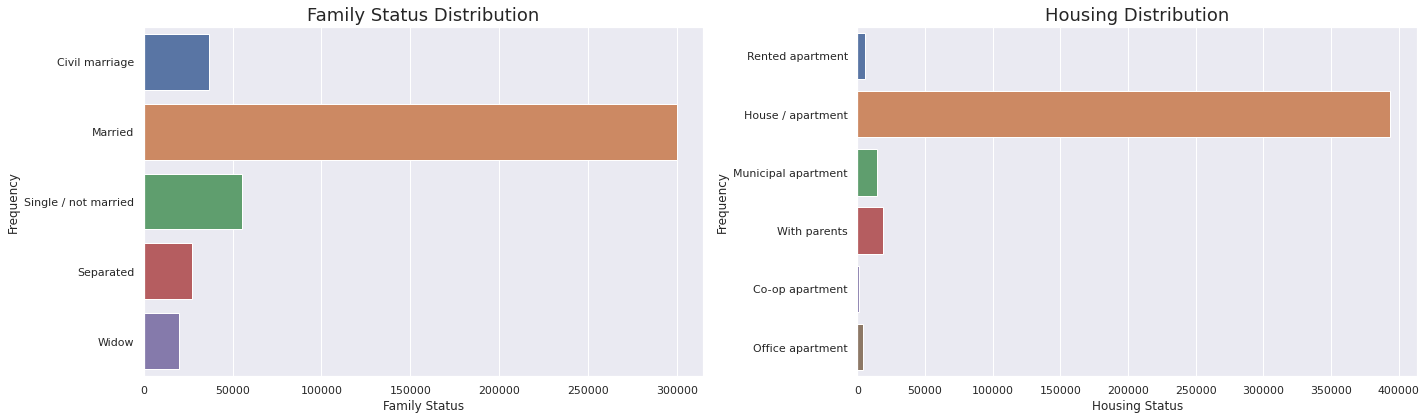

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sns.countplot(ax=ax[0], data = application_df, y = 'NAME_FAMILY_STATUS')
ax[0].set_xlabel('Family Status')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Family Status Distribution', fontsize=18)

sns.countplot(ax=ax[1], data = application_df, y = 'NAME_HOUSING_TYPE')
ax[1].set_xlabel('Housing Status')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Housing Distribution', fontsize=18)

plt.tight_layout()

Observation:
- Again, the data for Family Status and Housing Status are very imbalanced. Married and House/Apartment take up the majority of their own class feature.

In [ ]:
application_df.corr()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
ID,1.000000,-0.005178,0.011179,-0.004994,-0.002467,-0.023319,-0.018992,0.032875,-0.001862
CNT_CHILDREN,-0.005178,1.000000,0.019177,0.349088,-0.241535,0.038418,-0.038266,0.028457,0.884781
AMT_INCOME_TOTAL,0.011179,0.019177,1.000000,0.053775,-0.141291,-0.033635,0.004444,0.112139,0.011454
DAYS_BIRTH,-0.004994,0.349088,0.053775,1.000000,-0.617908,0.171829,-0.037984,0.096752,0.306179
DAYS_EMPLOYED,-0.002467,-0.241535,-0.141291,-0.617908,1.000000,-0.232208,0.004868,-0.074372,-0.234373
FLAG_WORK_PHONE,-0.023319,0.038418,-0.033635,0.171829,-0.232208,1.000000,0.290066,-0.060915,0.049777
FLAG_PHONE,-0.018992,-0.038266,0.004444,-0.037984,0.004868,0.290066,1.000000,-0.001170,-0.024213
FLAG_EMAIL,0.032875,0.028457,0.112139,0.096752,-0.074372,-0.060915,-0.001170,1.000000,0.022054
CNT_FAM_MEMBERS,-0.001862,0.884781,0.011454,0.306179,-0.234373,0.049777,-0.024213,0.022054,1.000000


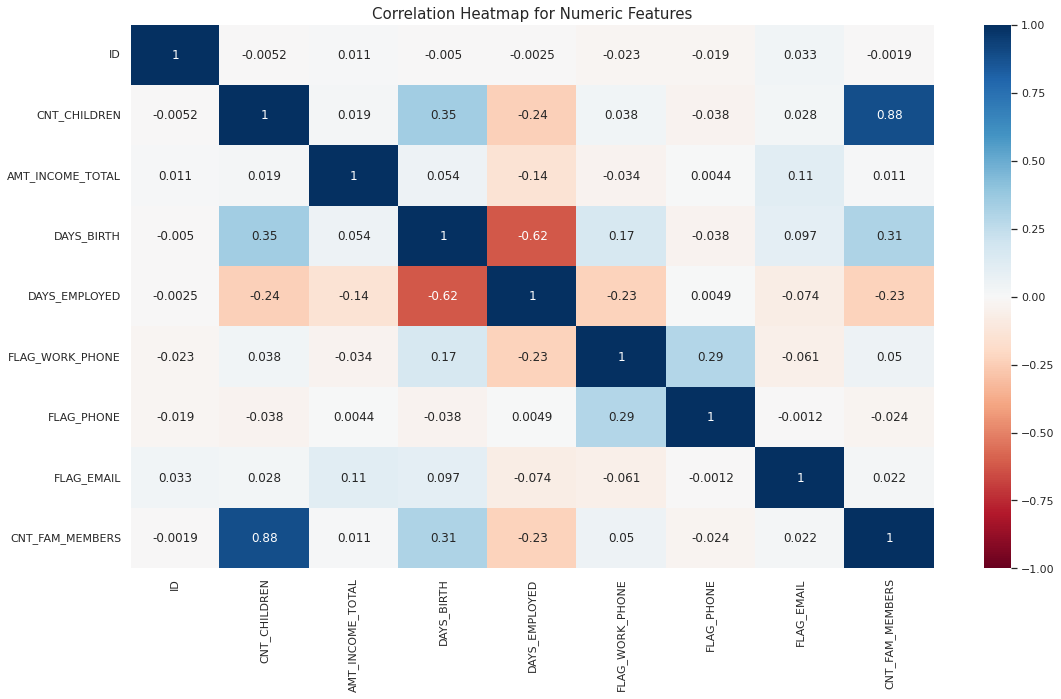

In [ ]:
corr_matrix = application_df.corr()
plt.figure(figsize=(18,10))
plt.title('Correlation Heatmap for Numeric Features', fontsize=15)
plt.xlabel('Features')
plt.ylabel('Features')
sns.heatmap(corr_matrix, cmap='RdBu', center = 0.0, vmax = 1.0, vmin = -1.0, annot=True)

Observation:

- From correlation matrix, most of the features are not correlated, which is good for training the model since we can avoid multicollinearlity.
- Only `CNT_CHILDREN` & `CNT_FAMILY_MEMBER`, and `DAYS_BIRTH` & `DAYS_EMPLOYED` are quite correlated, which makes sense based on their respective definitions. 

**Visualization of `credit_df`**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


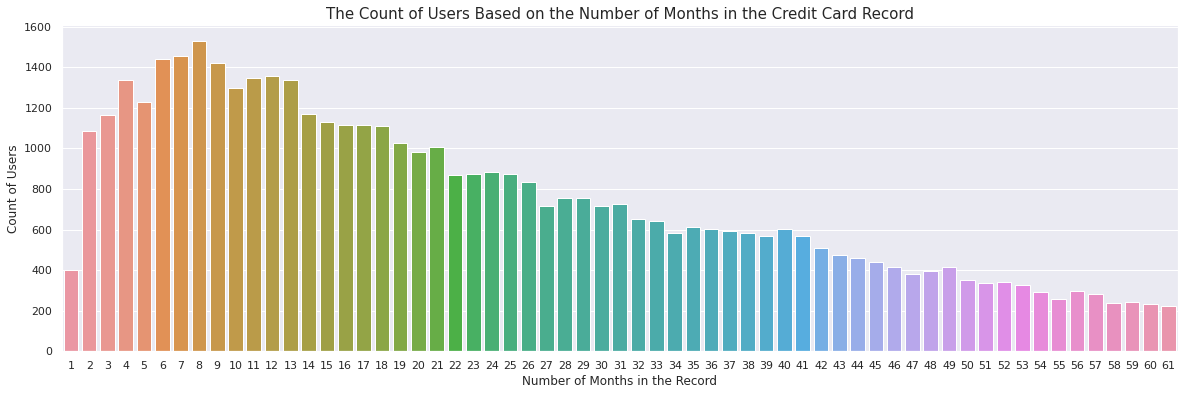

In [ ]:
plt.figure(figsize=(20,6))
sns.countplot(credit_df.groupby(by=['ID']).count()['MONTHS_BALANCE'])
plt.xlabel('Number of Months in the Record')
plt.ylabel('Count of Users')
plt.title('The Count of Users Based on the Number of Months in the Credit Card Record', fontsize = 15)
plt.show()

Observation:
- We see that the model for the above relationship approaches a normal distribution, but is right-skewed. This means that the mean is lower than the median.
- For each client ID, we usually have multiple rows keeping track of that client's record for multiple months.

In [ ]:
credit_df.groupby(by=['STATUS']).count()['ID']

STATUS
0    383120
1     11090
2       868
3       320
4       223
5      1693
C    442031
X    209230
Name: ID, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


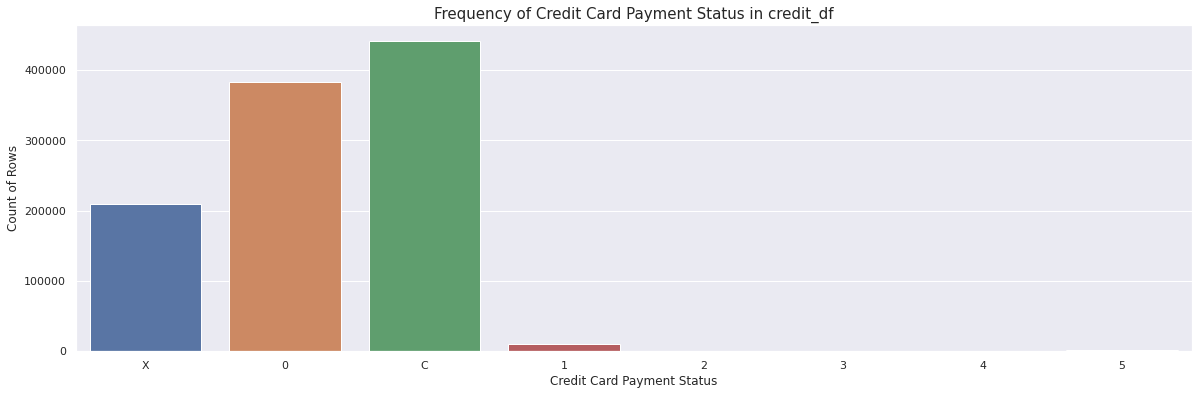

In [ ]:
plt.figure(figsize=(20,6))
sns.countplot(credit_df['STATUS'])
plt.xlabel('Credit Card Payment Status')
plt.ylabel('Count of Rows')
plt.title('Frequency of Credit Card Payment Status in credit_df', fontsize = 15)
plt.show()

Observation: 
- Most of the months, the loans are paid off in time or within a month. However, this doesn't mean that most users are good credit users since paying debts late once or twice hurt credit scores despite being on time most of the time.

**Note: Explanation of 'STATUS' column in credit_df**
 - 0: 1-29 days past due
 - 1: 30-59 days past due 
 - 2: 60-89 days overdue 
 - 3: 90-119 days overdue 
 - 4: 120-149 days overdue 
 - 5: Overdue or bad debts, write-offs for more than 150 days 
 - C: paid off that month 
 - X: No loan for the month

## **2.3 Feature Engineering**


### **2.3.1 Designing Target Variables**
- We will perform binary classification using our ML algorithms. First, we need to identify good (low-risk) and bad (high-risk) credit customers as to be our target variables:
 - **Bad Credit / High Risk (1):** The client is late on the payment (past due) *on average* more than a week (1/4 of the month).
 - **Good Credit / Low Risk (0):** The client is late on the payment (past due) *on average* less than a week (1/4 of the month).

- Note that one ID has multiple rows indicating the status of each month.

In [ ]:
target_df = credit_df[['ID','STATUS']]

# Convert X,C to 0 and add 1 to 0,1,2,3,4,5 to show 
# the number of month that the person is late for monthly debts
def status_classification(x):
  if x in ['X','C']:
    return 0
  else:
    # round up
    return int(x) + 1

target_df['TARGET'] = target_df['STATUS'].apply(status_classification)
target_df = target_df.groupby('ID').agg({'TARGET': 'mean'}).reset_index()
target_df['TARGET'] = target_df['TARGET'].apply(lambda x: np.where(x > 0.25, 1, 0))
# Show the number of target variables in our data: imbalanced
target_df['TARGET'].value_counts()

1    29801
0    16184
Name: TARGET, dtype: int64

Observation:
- Our target variables are imbalanced: the number of 0's is almost half less than 1's.
- Therefore, we need to oversample target=0 to tackle this imbalanced problem.


### **2.3.2 Converting Continuous Numerical Features**

We need to convert some columns so that we can obtain the features appropriate to input into our models as follows:

- Convert `DAYS_BIRTH` to 'Age'.
- Convert `DAYS_EMPLOYED` to 'Employment Status Indicator'.
- Convert `DAYS_EMPLOYED` to 'Year Employed' where higher number means longer employment period and zero means unemployed.
- Convert `CNT_FAM_MEMBERS` to integers since the values are discrete.

In [ ]:
# Create Age Column by dividing the total days from the person's birthday by 365.25 (# of days in a year)
application_df['AGE']= - application_df['DAYS_BIRTH'] / 365.25
application_df = application_df.drop(columns = ['DAYS_BIRTH'])

# Create Employment Status Indicator (0 = Employed, 1 = Unemployed)
# If application_df['DAYS_EMPLOYED'] is positive, it means the person is currently unemployed.
application_df['UNEMPLOYED'] = application_df['DAYS_EMPLOYED'].map(lambda x: np.where(x > 0, 1, 0))

# Convert DAYS_EMPLOYED column to 'Year Employed'  
# Higher number means longer employment period and zero means unemployed.
application_df['DAYS_EMPLOYED'] = application_df['DAYS_EMPLOYED'].apply(lambda x: np.where(x >= 0, 0, x))
application_df['YEAR_EMPLOYED'] = - application_df['DAYS_EMPLOYED'] / 365.25
application_df = application_df.drop(columns = ['DAYS_EMPLOYED'])

# Convert CNT_FAM_MEMBERS to int
application_df['CNT_FAM_MEMBERS'] = application_df['CNT_FAM_MEMBERS'].map(lambda x: int(x))

### **2.3.3 Encoding Categorial Features**
**Binary Features (1/0)**
- CODE_GENDER
- FLAG_OWN_CAR
- FLAG_OWN_REALTY

**Other Features (One-Hot Encoding/Label Encoding)**
- NAME_INCOME_TYPE
- NAME_EDUCATION_TYPE
- NAME_FAMILY_STATUS
- NAME_HOUSING_TYPE

Note that we only label encode education type since there is a ranking implication within education status.

In [ ]:
# Encoding Binary Features: Gender
application_df['CODE_GENDER'] = application_df['CODE_GENDER'].apply(lambda x: np.where(x == 'M', 1, 0))

# Encoding Binary Features: Car, House Ownership
application_df[['FLAG_OWN_CAR','FLAG_OWN_REALTY']] = application_df[['FLAG_OWN_CAR','FLAG_OWN_REALTY']].applymap(lambda x: np.where(x == 'Y', 1, 0))

# One-Hot Encode NAME_INCOME_TYPE and save all the columns in feature_df
feature_df = pd.get_dummies(application_df['NAME_INCOME_TYPE'])

# One-Hot Encode NAME_FAMILY_STATUS and concat with feature_df
dummy = pd.get_dummies(application_df['NAME_FAMILY_STATUS'])
feature_df = pd.concat([feature_df, dummy], axis=1)

# One-Hot Encode NAME_HOUSING_TYPE and concat with feature_df
dummy = pd.get_dummies(application_df['NAME_HOUSING_TYPE'])
feature_df = pd.concat([feature_df, dummy], axis=1)

# Label Encode NAME_EDUCATION_TYPE and concat with feature_df
# education_dummy = pd.get_dummies(application_df['NAME_EDUCATION_TYPE'])
def label_education(x):
  if x == 'Lower secondary':
    return 1
  elif x == 'Secondary / secondary special':
    return 2
  elif x == 'Incomplete higher':
    return 3
  elif x == 'Higher education':
    return 4
  else:
    return 5

feature_df['EDUCATION'] = application_df['NAME_EDUCATION_TYPE'].apply(label_education)

In [ ]:
# Obtain all features in feature_df (with ID as a key to join with target variables later)
application_df_feature = application_df[['ID','CODE_GENDER','FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',	'AMT_INCOME_TOTAL', 'FLAG_WORK_PHONE',	'FLAG_PHONE',	'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'AGE', 'UNEMPLOYED', 'YEAR_EMPLOYED']]
feature_df = pd.concat([application_df_feature,feature_df], axis=1)
feature_df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,AGE,UNEMPLOYED,YEAR_EMPLOYED,Commercial associate,Pensioner,State servant,Student,Working,Civil marriage,Married,Separated,Single / not married,Widow,Co-op apartment,House / apartment,Municipal apartment,Office apartment,Rented apartment,With parents,EDUCATION
0,5008804,1,1,1,0,427500.0,1,0,0,2,32.867899,0,12.435318,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,4
1,5008805,1,1,1,0,427500.0,1,0,0,2,32.867899,0,12.435318,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,4
2,5008806,1,1,1,0,112500.0,0,0,0,2,58.792608,0,3.104723,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,2
3,5008808,0,0,1,0,270000.0,0,1,1,1,52.320329,0,8.353183,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,2
4,5008809,0,0,1,0,270000.0,0,1,1,1,52.320329,0,8.353183,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,1,0,1,0,135000.0,0,0,0,1,62.195756,1,0.000000,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,2
438553,6840222,0,0,0,0,103500.0,0,0,0,1,43.638604,0,8.232717,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,2
438554,6841878,0,0,0,0,54000.0,1,0,0,1,22.365503,0,1.018480,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,4
438555,6842765,0,0,1,0,72000.0,0,0,0,2,59.337440,1,0.000000,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,2


**Observation**: We will not one-hot encode education, because given there are more than two possible education levels, it is difficult to one-hot encode education. Instead, we measure it from a scale of 1-5, depending on the progress.

## **2.4 Data Visualization (Revisited): After Feature-Engineering Target Variables**

We will join target_df with application_df through `'ID'`. Then, we will visualization the distribution of target variables for each feature.

In [ ]:
join_df = target_df.merge(application_df, on = 'ID', how='inner').drop_duplicates()

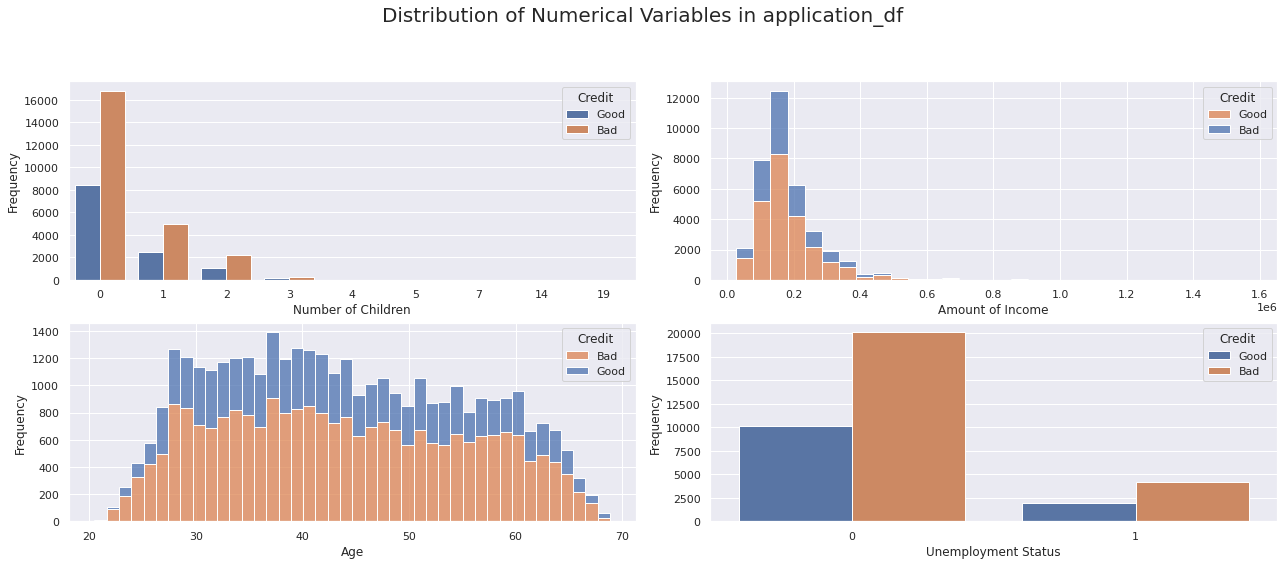

In [ ]:
# Distribution of numerical variables
fig, ax = plt.subplots(2, 2, figsize=(18, 8))
fig.suptitle('Distribution of Numerical Variables in application_df', fontsize=20)

sns.countplot(ax=ax[0,0], data = join_df, x = 'CNT_CHILDREN', hue = 'TARGET')
ax[0,0].set_xlabel('Number of Children')
ax[0,0].set_ylabel('Frequency')
ax[0,0].legend(title='Credit', loc='upper right', labels=['Good', 'Bad'])

sns.histplot(ax=ax[0,1], data = join_df, x = 'AMT_INCOME_TOTAL', bins=30, hue = 'TARGET', multiple="stack")
ax[0,1].set_xlabel('Amount of Income')
ax[0,1].set_ylabel('Frequency')
ax[0,1].legend(title='Credit', loc='upper right', labels=['Good', 'Bad'])

sns.histplot(ax=ax[1,0], data = join_df, x = 'AGE', hue = 'TARGET', multiple="stack")
ax[1,0].set_xlabel('Age')
ax[1,0].set_ylabel('Frequency')
ax[1,0].legend(title='Credit', loc='upper right', labels=['Bad', 'Good'])

sns.countplot(ax=ax[1,1], data = join_df, x = 'UNEMPLOYED', hue = 'TARGET')
ax[1,1].set_xlabel('Unemployment Status')
ax[1,1].set_ylabel('Frequency')
ax[1,1].legend(title='Credit', loc='upper right', labels=['Good', 'Bad'])

plt.tight_layout()
plt.subplots_adjust(top=0.85)

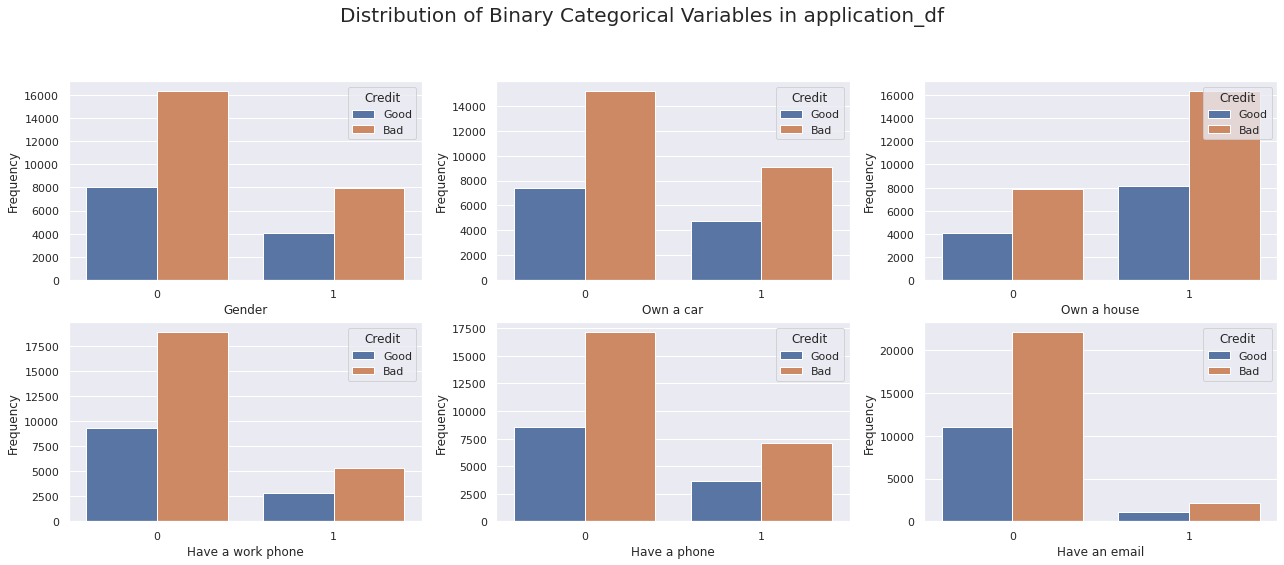

In [ ]:
# Distribution of binary categorical variables

fig, ax = plt.subplots(2, 3, figsize=(18, 8))
fig.suptitle('Distribution of Binary Categorical Variables in application_df', fontsize=20)

sns.countplot(ax=ax[0,0], data = join_df, x = 'CODE_GENDER', hue = 'TARGET')
ax[0,0].set_xlabel('Gender')
ax[0,0].set_ylabel('Frequency')
ax[0,0].legend(title='Credit', loc='upper right', labels=['Good', 'Bad'])

sns.countplot(ax=ax[0,1], data = join_df, x = 'FLAG_OWN_CAR', hue = 'TARGET')
ax[0,1].set_xlabel('Own a car')
ax[0,1].set_ylabel('Frequency')
ax[0,1].legend(title='Credit', loc='upper right', labels=['Good', 'Bad'])


sns.countplot(ax=ax[0,2], data = join_df, x = 'FLAG_OWN_REALTY', hue = 'TARGET')
ax[0,2].set_xlabel('Own a house')
ax[0,2].set_ylabel('Frequency')
ax[0,2].legend(title='Credit', loc='upper right', labels=['Good', 'Bad'])


sns.countplot(ax=ax[1,0], data = join_df, x = 'FLAG_WORK_PHONE', hue = 'TARGET')
ax[1,0].set_xlabel('Have a work phone')
ax[1,0].set_ylabel('Frequency')
ax[1,0].legend(title='Credit', loc='upper right', labels=['Good', 'Bad'])


sns.countplot(ax=ax[1,1], data = join_df, x = 'FLAG_PHONE', hue = 'TARGET')
ax[1,1].set_xlabel('Have a phone')
ax[1,1].set_ylabel('Frequency')
ax[1,1].legend(title='Credit', loc='upper right', labels=['Good', 'Bad'])


sns.countplot(ax=ax[1,2], data = join_df, x = 'FLAG_EMAIL', hue = 'TARGET')
ax[1,2].set_xlabel('Have an email')
ax[1,2].set_ylabel('Frequency')
ax[1,2].legend(title='Credit', loc='upper right', labels=['Good', 'Bad'])


plt.tight_layout()
plt.subplots_adjust(top=0.85)

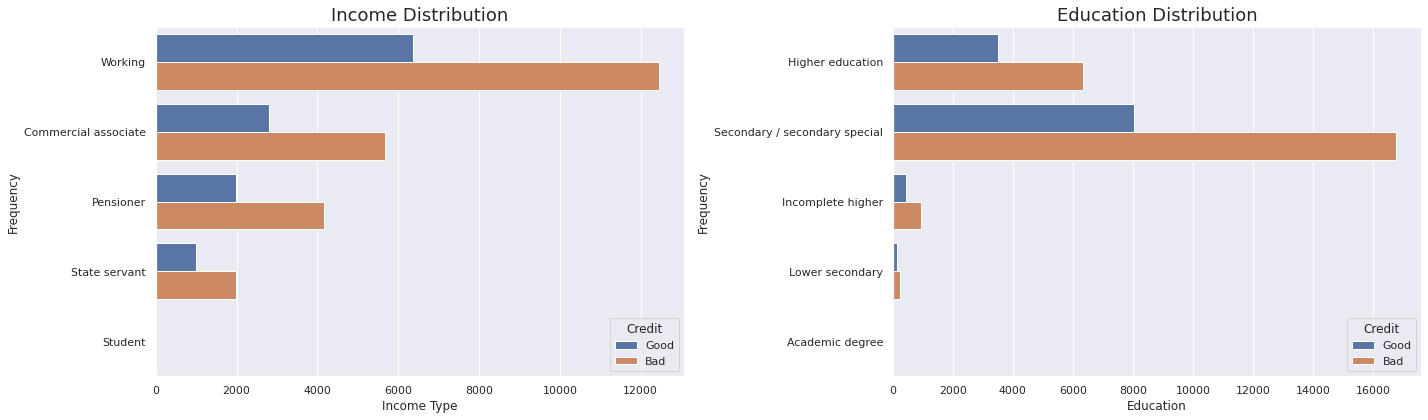

In [ ]:
# Distribution of Other categorial variables in application_df
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sns.countplot(ax=ax[0], data = join_df, y = 'NAME_INCOME_TYPE', hue = 'TARGET')
ax[0].set_xlabel('Income Type')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Income Distribution', fontsize=18)
ax[0].legend(title='Credit', loc='lower right', labels=['Good', 'Bad'])


sns.countplot(ax=ax[1], data = join_df, y = 'NAME_EDUCATION_TYPE', hue = 'TARGET')
ax[1].set_xlabel('Education')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Education Distribution', fontsize=18)
ax[1].legend(title='Credit', loc='lower right', labels=['Good', 'Bad'])


plt.tight_layout()

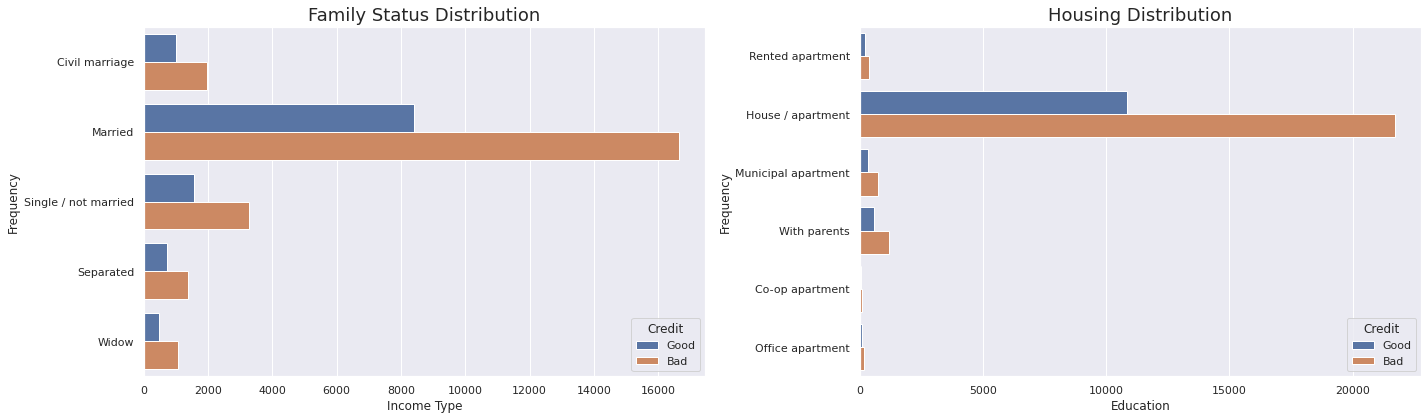

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sns.countplot(ax=ax[0], data = join_df, y = 'NAME_FAMILY_STATUS', hue = 'TARGET')
ax[0].set_xlabel('Income Type')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Family Status Distribution', fontsize=18)
ax[0].legend(title='Credit', loc='lower right', labels=['Good', 'Bad'])


sns.countplot(ax=ax[1], data = join_df, y = 'NAME_HOUSING_TYPE', hue = 'TARGET')
ax[1].set_xlabel('Education')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Housing Distribution', fontsize=18)
ax[1].legend(title='Credit', loc='lower right', labels=['Good', 'Bad'])


plt.tight_layout()

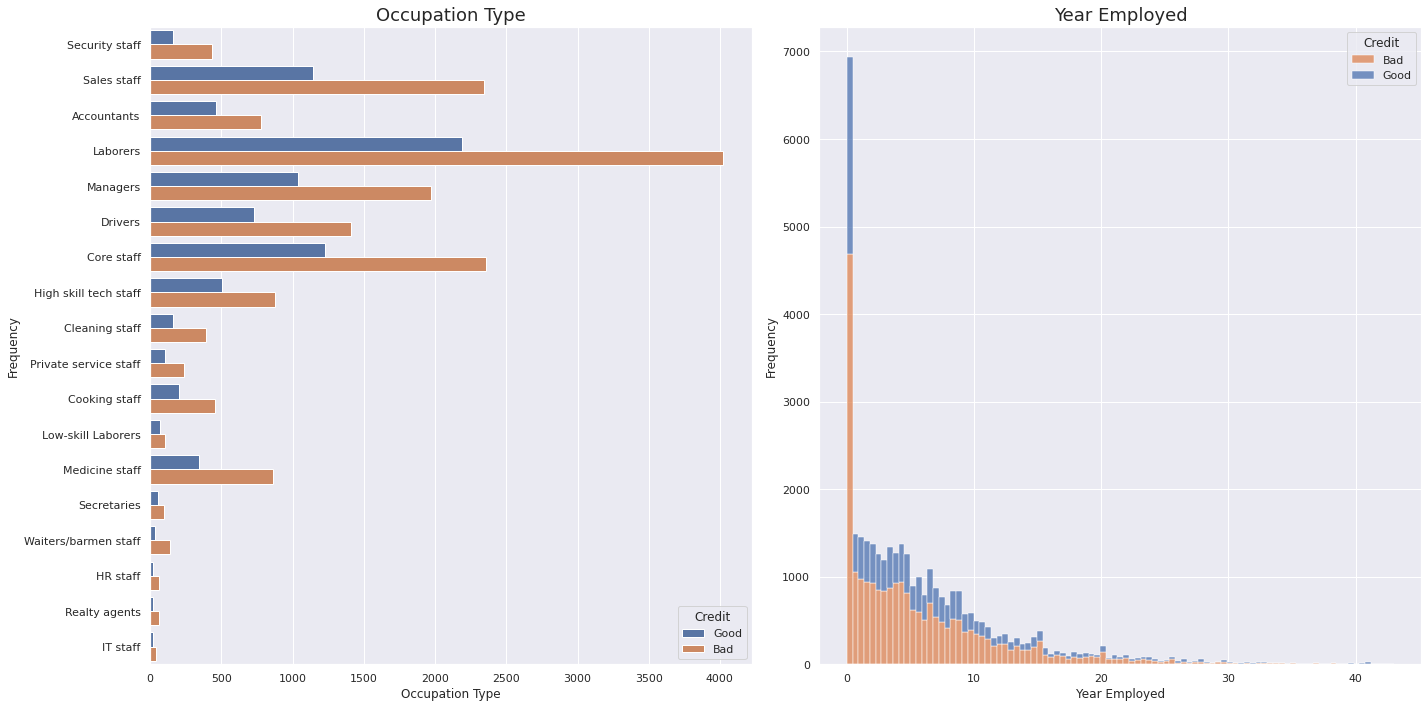

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

sns.countplot(ax=ax[0], data = join_df, y = 'OCCUPATION_TYPE', hue = 'TARGET')
ax[0].set_xlabel('Occupation Type')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Occupation Type', fontsize=18)
ax[0].legend(title='Credit', loc='lower right', labels=['Good', 'Bad'])


sns.histplot(ax=ax[1], data = join_df, x = 'YEAR_EMPLOYED', hue = 'TARGET', multiple="stack")
ax[1].set_xlabel('Year Employed')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Year Employed', fontsize=18)
ax[1].legend(title='Credit', loc='upper right', labels=['Bad', 'Good'])


plt.tight_layout()

**Observation**:
- We can see that our data is very imbalanced across all features. There are so many more bad credit users than good credit users.
- Thus, we have to oversample the minority class (bad = 1) using SMOTE before fitting the models.

# **3. Data Preprocessing For ML Algorithms**

## **3.1 Creating Features and Label for ML Algorithms**
- Recall that we have `feature_df` and `target_df` that are linked by `'ID'` column.
- Therefore, we will join these two tables together and split into features and labels that will be used in ML algorithms.

In [ ]:
feature_df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,AGE,UNEMPLOYED,YEAR_EMPLOYED,Commercial associate,Pensioner,State servant,Student,Working,Civil marriage,Married,Separated,Single / not married,Widow,Co-op apartment,House / apartment,Municipal apartment,Office apartment,Rented apartment,With parents,EDUCATION
0,5008804,1,1,1,0,427500.0,1,0,0,2,32.867899,0,12.435318,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,4
1,5008805,1,1,1,0,427500.0,1,0,0,2,32.867899,0,12.435318,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,4
2,5008806,1,1,1,0,112500.0,0,0,0,2,58.792608,0,3.104723,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,2
3,5008808,0,0,1,0,270000.0,0,1,1,1,52.320329,0,8.353183,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,2
4,5008809,0,0,1,0,270000.0,0,1,1,1,52.320329,0,8.353183,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,1,0,1,0,135000.0,0,0,0,1,62.195756,1,0.000000,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,2
438553,6840222,0,0,0,0,103500.0,0,0,0,1,43.638604,0,8.232717,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,2
438554,6841878,0,0,0,0,54000.0,1,0,0,1,22.365503,0,1.018480,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,4
438555,6842765,0,0,1,0,72000.0,0,0,0,2,59.337440,1,0.000000,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,2


In [ ]:
target_df = target_df[['ID','TARGET']]
target_df

,ID,TARGET
0,5001711,1
1,5001712,1
2,5001713,0
3,5001714,0
4,5001715,0
...,...,...
45980,5150482,1
45981,5150483,0
45982,5150484,1
45983,5150485,1


By inner joining `feature_df` and `target_df`, we remove any duplicates using the ID column, which is then dropped.

In [ ]:
# Complete dataframes with features and target variables
complete_df = feature_df.merge(target_df, how='inner', on='ID').drop(columns = 'ID')

# Feature dataframe
features = complete_df.drop(columns='TARGET')

#Label/Target Dataframe
label = complete_df['TARGET']

In [ ]:
features.shape[0] == label.size

True

Now, we have `features` and `label`, which are ready to be used for our ML algorithms!

## **3.2 Train-Test Split, Standard Scaler, and Principle Component Analysis (PCA)**
- We want to do train-test split 80/20 on our data.
- We want to standardize `x_train` and `x_test` to have zero mean and unit variance using `x_train`'s mean and standard deviation.
- We use PCA to reduce high numbers of correlated features to low numbers of uncorrelated features. This practice not only makes it easier to visualize the data, but also reduces noise in the data for supervised learning.


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.model_selection import train_test_split

**Train-Test Split**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)

**Standard Scaler**

In [ ]:
# Fit & transform StandardScaler() on x_train but only transform on x_test
scaler = StandardScaler()
x_train_sc = scaler.fit_transform(x_train)
x_test_sc = scaler.transform(x_test)

**Principle Component Analysis (PCA)**
- We will plot the _cumulative_ `explained_variance_ratio` against the number of components to decide the number of components we will keep.

Text(0, 0.5, 'Cumulative Explained Variance Ratio')

<Figure size 864x576 with 0 Axes>

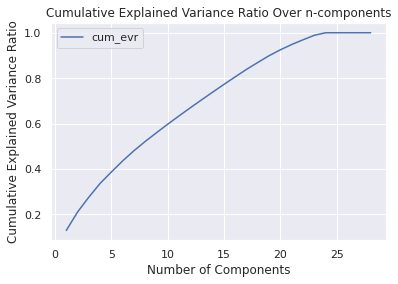

In [ ]:
pca = PCA(n_components=28)
x_train_pca = pca.fit_transform(x_train_sc)

# Find cumulative explained variance ratios
explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = pca.explained_variance_ratio_.cumsum()

# Plot cum_evr graph
df = pd.DataFrame({
    'x': range(1, 29),
    'cum_evr': cum_evr
})
plt.figure(figsize=(12,8))
df.plot(x = 'x', y = 'cum_evr')
plt.title("Cumulative Explained Variance Ratio Over n-components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")

The cumulative explained variance ratio converges at  around 23 components, so we should keep 23 components for PCA.

In [ ]:
pca_new = PCA(n_components=23)
x_train_pca = pca_new.fit_transform(x_train_sc)
x_test_pca = pca_new.transform(x_test_sc)

## **3.3 SMOTE: Oversampling Minority Class**
- As shown below, class 0 contains significantly less data than class 1 in our targets. Thus, we have to oversample class 0 in our training data to tackle data imbalance.
- We will SMOTE on both 'x_train' and 'x_train_pca' since some models such as decision-tree based models are scale-invariant.

In [ ]:
y_train.value_counts()

1    19472
0     9693
Name: TARGET, dtype: int64

In [ ]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

# PCA training data
smote = SMOTE()
x_train_smote, y_train_smote = smote.fit_resample(x_train_pca, y_train)

# non-PCA training data
smote = SMOTE()
x_train_smote_nopca, y_train_smote = smote.fit_resample(x_train, y_train)

# Show number of samples
print("Before SMOTE: ", Counter(y_train))
print("After SMOTE: ", Counter(y_train_smote))

Before SMOTE:  Counter({1: 19472, 0: 9693})
After SMOTE:  Counter({1: 19472, 0: 19472})


Now, we have training and testing data ready for ML algorithms.

**Recap of our test and train data variables:**

*Scale-Variant Model* (Use data with SC and PCA):
- 'x_train_smote (SC, PCA, SMOTE)
- 'y_train_smote' (SMOTE)
- 'x_test_pca' (SC, PCA)
- 'y_test'

*Scale-Invariant Model* (Use data with no SC and PCA):
- 'x_train_smote_nopca' (SMOTE)
- 'y_train_smote' (SMOTE)
- 'x_test'
- 'y_test'

# **4. Machine Learning Algorithms**

## Model 0 (Baseline): Always Predict Majority Class
We will use the model which always predict the majority class, i.e. target = 1 (bad credit users), as our baseline model to beat.

In [ ]:
# Store the prediction in test_pred, which is an array of 1's
major_list = [1] * y_test.shape[0]
test_pred = pd.Series(major_list)
test_pred

0       1
1       1
2       1
3       1
4       1
       ..
7287    1
7288    1
7289    1
7290    1
7291    1
Length: 7292, dtype: int64

In [ ]:
# Accuracy (Percentage of 1 in y_train)
train_acc_base = y_train_smote.value_counts()[1] / y_train_smote.shape[0]
print('Training Accuracy: ', train_acc_base)
# Accuracy (Percentage of 1 in y_test)
test_acc_base = y_test.value_counts()[1] / y_test.shape[0]
print('Testing Accuracy: ', test_acc_base)
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cf_matrix_base = confusion_matrix(y_test, test_pred)
print('Confusion Matrix:')
print(cf_matrix_base)
# ROC AUC Score
from sklearn.metrics import roc_auc_score
roc_base = roc_auc_score(y_test, test_pred)
print('ROC AUC Score: ', roc_base)
# F-1 measure
from sklearn.metrics import fbeta_score
f1_base = fbeta_score(y_test, test_pred, beta=1.0)
print('F-1 Score: ', f1_base)

Training Accuracy:  0.5
Testing Accuracy:  0.6625068568294021
Confusion Matrix:
[[   0 2461]
 [   0 4831]]
ROC AUC Score:  0.5
F-1 Score:  0.7969974428771757


Text(0.5, 0, 'False Positive Rate')

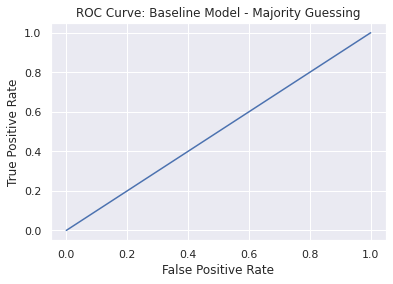

In [ ]:
# ROC Curve
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test, test_pred)
plt.plot(fpr, tpr)
plt.title('ROC Curve: Baseline Model - Majority Guessing')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

**Intitial Analysis of Performance Metrics**
- Based on our domain knowledge of credit card (loan) approval and from the perspectives of financial institutions, it is worse to approve credit cards for bad credit users than reject credit cards fpr good credit users.
- Therefore, we want to minimize false negative (pred = 0, actual = 1). Recall that 0 means good credit users.
- As a result, an appropriate metric on top of *accuracy* is *Recall/Sensitivity/True Positive Rate (TP/FN+TP)*.
- However, our baseline model always predict that the users are bad, so the recall is 1. Thus, we cannot compare recall to this baseline model but can try to minimize false negative as much as possible in our model.
- We will also use *AUC ROC Score* as another metric to assess the trade-off between sensitivity and specificity and to beat our random guessing model which has the score of 0.5


In summary, we will be evaluating **Recall** and **AUC ROC Score** for different ML algorithms.

## Model 1: Logistic Regression
- Since Logistic Regression is scale sensitive, we will use data that we did PCA.

In [ ]:
from sklearn.linear_model import LogisticRegression
# Fit the model
LR = LogisticRegression()
LR.fit(x_train_smote, y_train_smote)
# Predict
train_pred = LR.predict(x_train_smote)
test_pred = LR.predict(x_test_pca)

In [ ]:
# Accuracy
train_acc_log = LR.score(x_train_smote, y_train_smote)
test_acc_log = LR.score(x_test_pca, y_test)
print('Train Accuracy: ', train_acc_log)
print('Test Accuracy: ', test_acc_log)
# Confusion Matrix
cf_matrix_log = confusion_matrix(y_test, test_pred)
print('Confusion Matrix:')
print(cf_matrix_log)
# Recall
TP = cf_matrix_log[1][1]
FN = cf_matrix_log[1][0]
recall_log = TP / (FN + TP)
print('Recall: ', recall_log)
# ROC AUC Score
probability = LR.predict_proba(x_test_pca)[:, 1]
roc_log = roc_auc_score(y_test, probability)
print('ROC AUC Score: ', roc_log)
# F-1 Score
f1_log = fbeta_score(y_test, test_pred, beta=1.0)
print('F-1 Score: ', f1_log)

Train Accuracy:  0.519258422350041
Test Accuracy:  0.5274273176083379
Confusion Matrix:
[[1159 1302]
 [2144 2687]]
Recall:  0.5561995446077417
ROC AUC Score:  0.5192195517722927
F-1 Score:  0.609297052154195


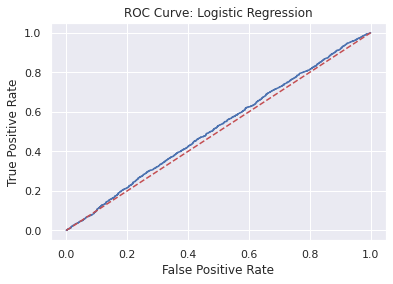

In [ ]:
# ROC Curve
fpr_log, tpr_log, _ = metrics.roc_curve(y_test, probability)
plt.plot(fpr_log, tpr_log)
plt.title('ROC Curve: Logistic Regression')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1],'r--')

**Performance Analysis:**
- The accuracy is even worse than majority guessing in our baseline model.
- Recall is relatively low as well, which is the important metric for this domain as discussed earlier.
- ROC AUC Score is also very close to random guessing.

## Model 2: Random Forest
- We will use Grid Search Cross Validation (GridSearchCV) to find the best hyperparameters.
- Note that Randome Forest is scale-invariant, so we will use unscaled, non-PCA data.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

rf = RandomForestClassifier()
params = {
    "max_depth": [8, 64],
    "n_estimators": [50, 200],
}
rf_cv = GridSearchCV(rf, params, verbose=3, n_jobs=-1, scoring='accuracy')
rf_cv.fit(x_train_smote_nopca, y_train_smote)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [8, 64], 'n_estimators': [50, 200]},
             scoring='accuracy', verbose=3)

- Here, we apply **GridSearch Cross Validation** to search for the best set of paramters for our random forest. Because of the constraint on procesing, we were only able to have 2 options for each paramter. 
- Calling best_params_ below gives us the best parameters (that give the highest accuracy)


In [ ]:
print(f'Best Parameters with Highest Accuracy: {rf_cv.best_params_}')

# Instantiate RF with chosen hyperparameters
rf = RandomForestClassifier(**rf_cv.best_params_)

# Fit to original data
rf.fit(x_train_smote_nopca, y_train_smote)

# Predict on training and testing sets
train_pred = rf.predict(x_train_smote_nopca)
test_pred = rf.predict(x_test)

Best Parameters with Highest Accuracy: {'max_depth': 64, 'n_estimators': 200}


In [ ]:
# Accuracy
train_acc_random = rf.score(x_train_smote_nopca, y_train_smote)
test_acc_random = rf.score(x_test, y_test)
print('Train Accuracy: ', train_acc_random)
print('Test Accuracy: ', test_acc_random)
# Confusion Matrix
cf_matrix_random = confusion_matrix(y_test, test_pred)
print('Confusion Matrix:')
print(cf_matrix_random)
# Recall
TP = cf_matrix_random[1][1]
FN = cf_matrix_random[1][0]
recall_random = TP / (FN + TP)
print('Recall: ', recall_random)
# ROC AUC Score
probability = rf.predict_proba(x_test)[:, 1]
roc_random = roc_auc_score(y_test, probability)
print('ROC AUC Score', roc_random)
# F-1 Score
f1_random = fbeta_score(y_test, test_pred, beta=1.0)
print('F-1 Score: ', f1_random)

Train Accuracy:  0.8537900575184881
Test Accuracy:  0.6947339550191991
Confusion Matrix:
[[1363 1098]
 [1128 3703]]
Recall:  0.7665079693645208
ROC AUC Score 0.7307442175352178
F-1 Score:  0.7688953488372092


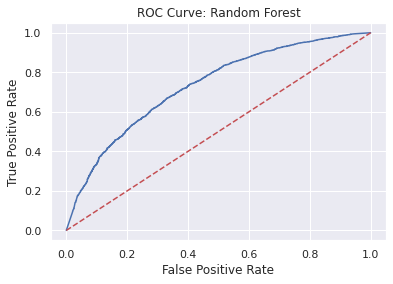

In [ ]:
# ROC Curve
fpr_random, tpr_random, _ = metrics.roc_curve(y_test, probability)
plt.plot(fpr_random, tpr_random)
plt.title('ROC Curve: Random Forest')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1],'r--')

**Performance Analysis:**
- The accuracy of both testing and training data is a lot higher than logistic regression. The accuracy of testing data is 4% better than the baseline model which guessed the majority class. Since our data is imbalanced, this baseline accuracy is quite challenging to beat, yet our model did better.
- The model seems to be a little bit overfit since the accuracy of testing data is around 15 percentage point lower than that of training data. We tried to tune parameters to combat overfit (increasing `n_estimators` to increase the number of trees, reducing `max_depth` to reduce the complexity of the learned models, etc.) but did not turn out to help.
- Recall (TPR) is quite satisfactory (0.78) since minimizing false negative is important in credit card approval.
- ROC AUC Score is also significantly higher than the baseline model and Logistic Regression.
- We will next use Gradient Boosting, which corrects the mistakes of previous learners by fitting patterns in residuals, to see if we can perform better.


## Model 3: XGBoost
- Decision-tree-based ensemble ML Algorithm, which utilizes *gradient boosting* framework.
- We will again use GridSearchCV to find the best hyperparameters.

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

xg = xgb.XGBClassifier()
params = {
    "max_depth": [8, 32],
    "n_estimators": [100, 200],
    "learning_rate" : [0.01, 0.1],   
}
xg_cv = RandomizedSearchCV(xg, params, verbose=3, n_jobs=-1, scoring='accuracy', n_iter=3)
xg_cv.fit(x_train_smote_nopca, y_train_smote)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


RandomizedSearchCV(estimator=XGBClassifier(), n_iter=3, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1],
                                        'max_depth': [8, 32],
                                        'n_estimators': [100, 200]},
                   scoring='accuracy', verbose=3)

Instead of GridSearch, we implement RandomizedSearch to determine the best set of parameters. The biggest difference is that since values are selected at random, it generally takes less computation and run time.

In [ ]:
print(f'Best Parameters with Highest Accuracy: {xg_cv.best_params_}')

# Instantiate RF with chosen hyperparameters
XG = xgb.XGBClassifier(**xg_cv.best_params_)

# Fit the model
XG.fit(x_train_smote_nopca, y_train_smote)

# Predict
train_pred = XG.predict(x_train_smote_nopca)
test_pred = XG.predict(x_test)

Best Parameters with Highest Accuracy: {'n_estimators': 100, 'max_depth': 32, 'learning_rate': 0.01}


In [ ]:
# Accuracy
train_acc_xg = XG.score(x_train_smote_nopca, y_train_smote)
test_acc_xg = XG.score(x_test, y_test)
print('Train Accuracy: ', train_acc_random)
print('Test Accuracy: ', test_acc_random)
# Confusion Matrix
cf_matrix_xg = confusion_matrix(y_test, test_pred)
print('Confusion Matrix: ')
print(cf_matrix_xg)
# Recall
TP = cf_matrix_xg[1][1]
FN = cf_matrix_xg[1][0]
recall_xg = TP / (FN + TP)
print('Recall: ', recall_xg)
# ROC AUC Score
probability = XG.predict_proba(x_test)[:, 1]
roc_xg = roc_auc_score(y_test, probability)
print('ROC AUC Score: ', roc_xg)
# F-1 Score
f1_xg = fbeta_score(y_test, test_pred, beta=1.0)
print('F-1 Score: ', f1_xg)

Train Accuracy:  0.8537900575184881
Test Accuracy:  0.6947339550191991
Confusion Matrix: 
[[1375 1086]
 [1178 3653]]
Recall:  0.7561581453115297
ROC AUC Score:  0.7137628520128242
F-1 Score:  0.7634273772204807


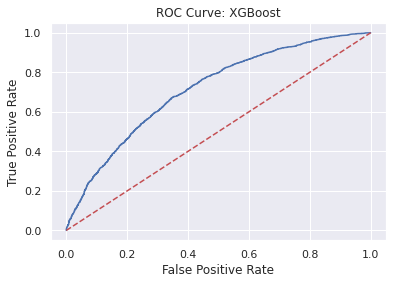

In [ ]:
# ROC Curve
fpr_xg, tpr_xg, _ = metrics.roc_curve(y_test, probability)
plt.plot(fpr_xg, tpr_xg)
plt.title('ROC Curve: XGBoost')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1],'r--')

**Performance Analysis:**
- XGBoost performed very similarly to Random Forest in all metrics despite having gradient boosting.
- Again, the model seems to be a little bit overfit, so we tried to tune parameters to combat overfit (reducing `learning_rate`, increasing `n_estimators` to increase the number of trees, reducing `max_depth` to reduce the complexity of the learned models, etc.) but did not turn out to help.

## Model 4: K-Nearest Neighbor Classifier
- KNN is not scale invariant so we need to use data we did PCA.

In [ ]:
# Fit the model
from sklearn.neighbors import KNeighborsClassifier
KN = KNeighborsClassifier()
KN.fit(x_train_smote, y_train_smote)
# Predict
train_pred = KN.predict(x_train_smote)
test_pred = KN.predict(x_test_pca)

In [ ]:
# Accuracy
train_acc_kn = KN.score(x_train_smote, y_train_smote)
test_acc_kn = KN.score(x_test_pca, y_test)
print('Train Accuracy: ', train_acc_kn)
print('Test Accuracy: ', test_acc_kn)
# Confusion Matrix
cf_matrix_kn = confusion_matrix(y_test, test_pred)
print('Confusion Matrix: ')
print(cf_matrix_kn)
# Recall
TP = cf_matrix_kn[1][1]
FN = cf_matrix_kn[1][0]
recall_kn = TP / (FN + TP)
print('Recall: ', recall_kn)
# ROC AUC Score
probability = KN.predict_proba(x_test_pca)[:, 1]
roc_kn = roc_auc_score(y_test, probability)
print('ROC AUC Score: ', roc_kn)
# F-1 Score
f1_kn = fbeta_score(y_test, test_pred, beta=1.0)
print('F-1 Score: ', f1_kn)

Train Accuracy:  0.7926253081347576
Test Accuracy:  0.6533187054306089
Confusion Matrix: 
[[1455 1006]
 [1522 3309]]
Recall:  0.684951355826951
ROC AUC Score:  0.6778046782550491
F-1 Score:  0.723595014213864


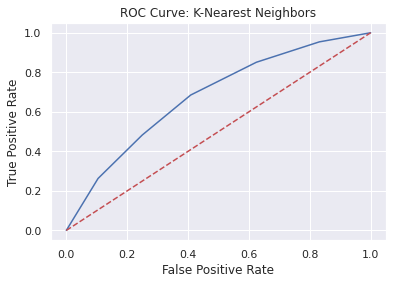

In [ ]:
# ROC Curve
fpr_kn, tpr_kn, _ = metrics.roc_curve(y_test, probability)
plt.plot(fpr_kn, tpr_kn)
plt.title('ROC Curve: K-Nearest Neighbors')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1],'r--')

**Performance Analysis:**
- KNN performed worse than Random Forest and XGBoost in all metrics.
- The model seems to be overfit since the testing accuracy dropped by 15 percentage point from 80% to 65%

# **5. Performance & Metric Evaluation**

## Metric 1: Accuracy

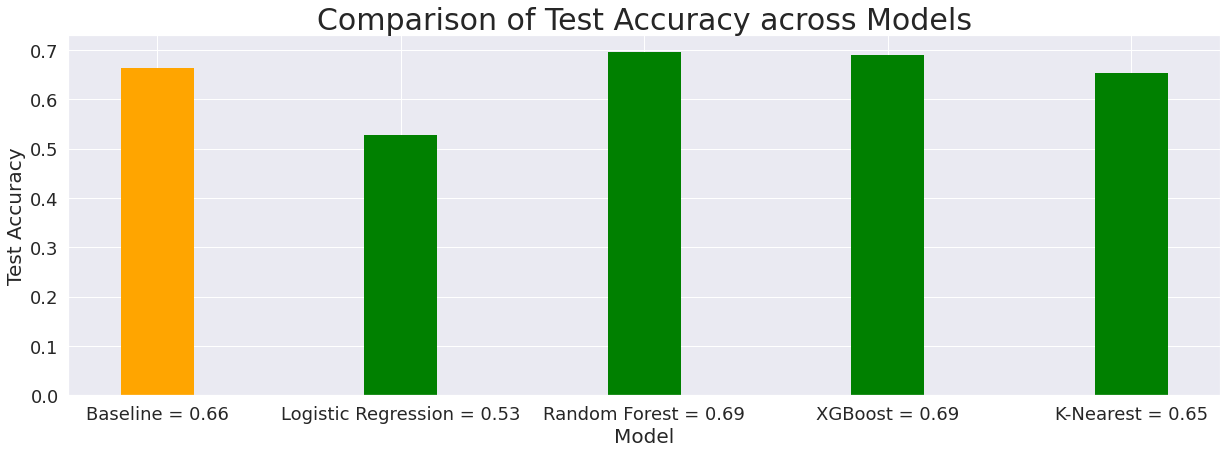

In [ ]:
fig = plt.figure(figsize=(18, 10))
fig.set_figheight(5)
fig.set_figwidth(16)
ax = fig.add_axes([0,0,1,1])
sns.reset_defaults()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(18)
models = [f'Baseline = {round(test_acc_base, 2)}', f'Logistic Regression = {round(test_acc_log, 2)}', f'Random Forest = {round(test_acc_random, 2)}', f'XGBoost = {round(test_acc_xg, 2)}', f'K-Nearest = {round(test_acc_kn, 2)}']
test_acc = [test_acc_base,test_acc_log,test_acc_random,test_acc_xg,test_acc_kn]
ax.bar(models, test_acc, width = 0.3, color = ['orange', 'green', 'green', 'green', 'green'])
plt.xlabel('Model', fontsize = 20)
plt.ylabel('Test Accuracy', fontsize = 20)
plt.title('Comparison of Test Accuracy across Models', fontsize = 30)
plt.show()

**Analysis:**
- The baseline model predicting the majority class has a relatively high test accuracy. This is due to the fact that our data is largely imbalanced and thus skewed towards bad credit users.
- Upon this observation, we tried to refine the definition of bad and good credit users by recreating the target variables. Instead of penalizing users who paid their loans late at least once, we used a more realistic approach by categorizing users who paid on average more than a week late as bad credit users. In other words, paying late once does not mark the applicant a bad user. Meanwhile, the clients can improve credit scores again by paying on time consistently afterwards.
- Our model accuracy improved upon this reclassification of target variables. However, the difficult question is how much should the average threshold be? 5 days, one week, a month, etc. Or is there any other precise cut-off to classify target variables. This is beyond our knowledge and beyond the scope of this project.
- That being said, we can still draw a conclusion that test accuracy is not the most relevant metric we should use when evaluating our models since our training and testing data are imbalanced. If we have another testing data that are more balanced, the importance of accuracy metric would increase accordingly. 
- The two decision-tree based models, Random Forest and XGBoost, performed the best in terms of test accuracies. This could be attributed to the use of cross validation methods, including RandomSearch and GridSearch, which systematically calculated for the best set of paramters in each case.

## Metric 2: ROC Curve & ROC AUC Score

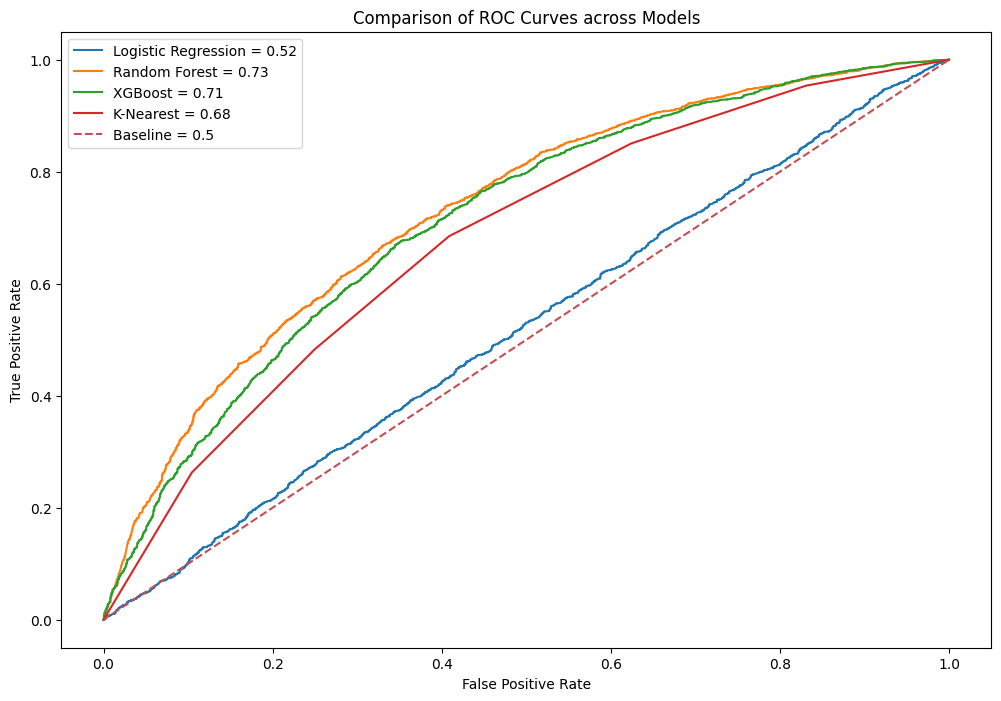

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(fpr_log, tpr_log)
plt.plot(fpr_random, tpr_random)
plt.plot(fpr_xg, tpr_xg)
plt.plot(fpr_kn, tpr_kn)
plt.plot([0, 1], [0, 1],'r--')
plt.legend([f'Logistic Regression = {round(roc_log, 2)}', f'Random Forest = {round(roc_random, 2)}', f'XGBoost = {round(roc_xg, 2)}', f'K-Nearest = {round(roc_kn, 2)}', 'Baseline = 0.5'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curves across Models')
plt.show()

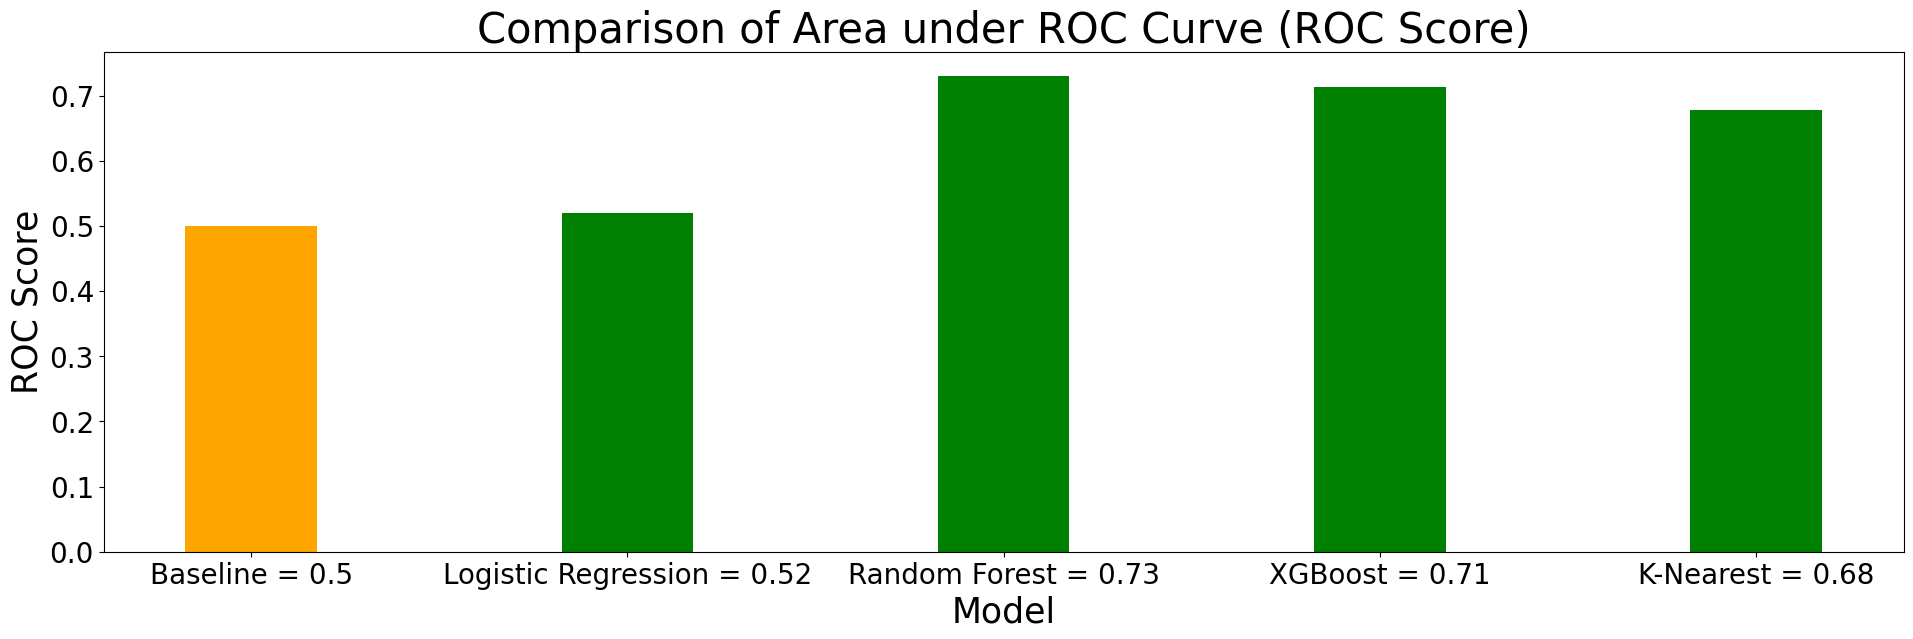

In [ ]:
fig = plt.figure(figsize=(18, 10))
fig.set_figheight(5)
fig.set_figwidth(18)
ax = fig.add_axes([0,0,1,1])
sns.reset_defaults()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(20)
models = ['Baseline = 0.5', f'Logistic Regression = {round(roc_log, 2)}', f'Random Forest = {round(roc_random, 2)}', f'XGBoost = {round(roc_xg, 2)}', f'K-Nearest = {round(roc_kn, 2)}']
roc_scores = [0.5,roc_log,roc_random,roc_xg,roc_kn]
ax.bar(models, roc_scores, width = 0.35, color = ['orange', 'green', 'green', 'green', 'green'])
plt.xlabel('Model', fontsize = 25)
plt.ylabel('ROC Score', fontsize = 25)
plt.title('Comparison of Area under ROC Curve (ROC Score)', fontsize = 30)
plt.show()

**Analysis:**
- The Receiver Operator Characteristic (ROC) Curve summarizes the trade-offs between the true positive rate (sensitivity/recall) and false positive rate for the ML model by varying probability thresholds.
- The Area Under the Curve (AUC) Score is used to summarized the ROC curve. Higher AUC means the better the model is at distinguishing between the positive and negative classes.
- The ROC Curve is an evaluation metric for binary classification problems, and therefore is suitable for evaluating our models.
- Since baseline model predicts constant class for all the data points, the AUC Score is 0.5, and AUC is a good metric to evaluate how much better we can beat the baseline model.
- Our Random Forest and XGBoost performed the best on AUC Score as expected, while logistic regression performed worst, very close to the 0.5 threshold.

## Metric 3: Confusion Matrix & Recall (True Positive Rate)

Text(58.25, 0.5, 'Actual')

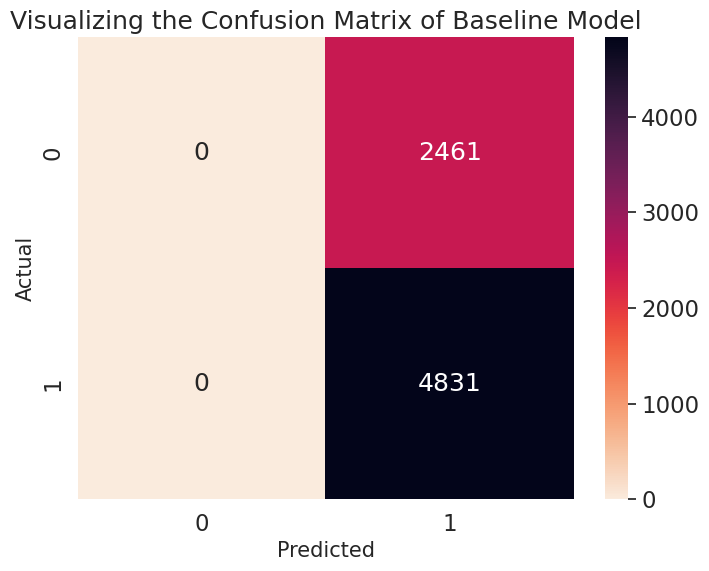

In [ ]:
fig = plt.figure(figsize=(8, 6))
sns.set(font_scale=1.5) 
sns.heatmap(cf_matrix_base, annot=True, fmt ='d', cmap='rocket_r')
plt.title('Visualizing the Confusion Matrix of Baseline Model', fontsize = 18)
plt.xlabel('Predicted', fontsize = 15)
plt.ylabel('Actual', fontsize = 15)

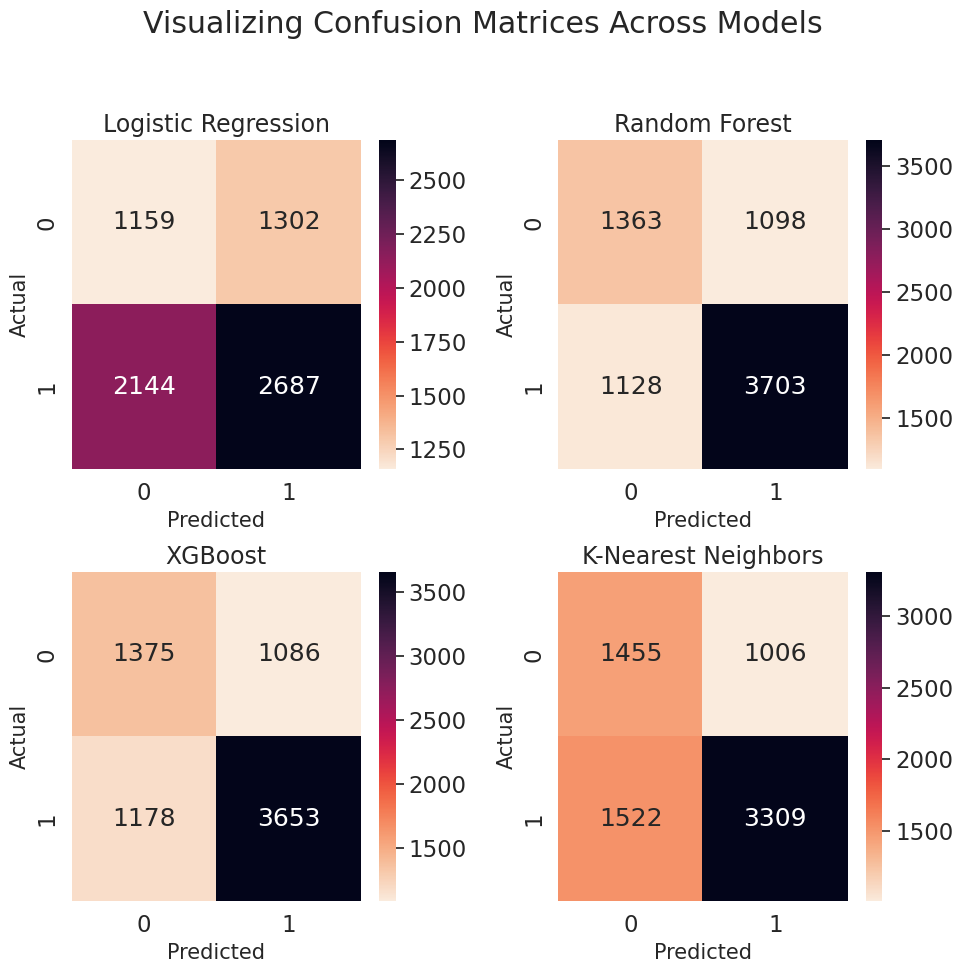

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))
fig.suptitle('Visualizing Confusion Matrices Across Models')

sns.heatmap(ax = axes[0,0], data=cf_matrix_log, annot=True, fmt ='d', cmap='rocket_r')
sns.heatmap(ax = axes[0,1], data=cf_matrix_random, annot=True, fmt ='d', cmap='rocket_r')
sns.heatmap(ax = axes[1,0], data=cf_matrix_xg, annot=True, fmt ='d', cmap='rocket_r')
sns.heatmap(ax = axes[1,1], data=cf_matrix_kn, annot=True, fmt ='d', cmap='rocket_r')


axes[0,0].set_xlabel('Predicted', fontsize=15)
axes[0,0].set_ylabel('Actual', fontsize=15)
axes[0,0].set_title('Logistic Regression', fontsize=17)

axes[0,1].set_xlabel('Predicted', fontsize=15)
axes[0,1].set_ylabel('Actual', fontsize=15)
axes[0,1].set_title('Random Forest', fontsize=17)

axes[1,0].set_xlabel('Predicted', fontsize=15)
axes[1,0].set_ylabel('Actual', fontsize=15)
axes[1,0].set_title('XGBoost', fontsize=17)

axes[1,1].set_xlabel('Predicted', fontsize=15)
axes[1,1].set_ylabel('Actual', fontsize=15)
axes[1,1].set_title('K-Nearest Neighbors', fontsize=17)

plt.tight_layout()
plt.subplots_adjust(top=0.85)

**Analysis:** 
*   From visualizing the confusion matrices across models, we were able to gain a big-picture understanding of our models' performance. Note that since the baseline model predicted all users as bad users, there were 0 users in the true negative and false positive categories.

*   We could also compare the performance amongst all four models. The logistic regression model predicted a comparable amount of false negatives compared to the true positive, which implies that the model predicts bad users as good users just as much as it does when it correctly flags bad users.

*   On the other hand, the Random Forest and XGBoost models have similar performances. We can observe that the colors for the true negatives and true positive cells are significantly darker than the other two. This observation highlights that the two models have considerably less false negatives and false positives.

*   Lastly, the K-Nearest Neighbors model has a relatively poor performance on predicting true negatives from false negatives. However, we can observe that the model minimizes the amount of false positives, which is the equivalent of predicting good users as bad users. Still, we would prefer the model that minimizes false negatives more, which will be discussed later.

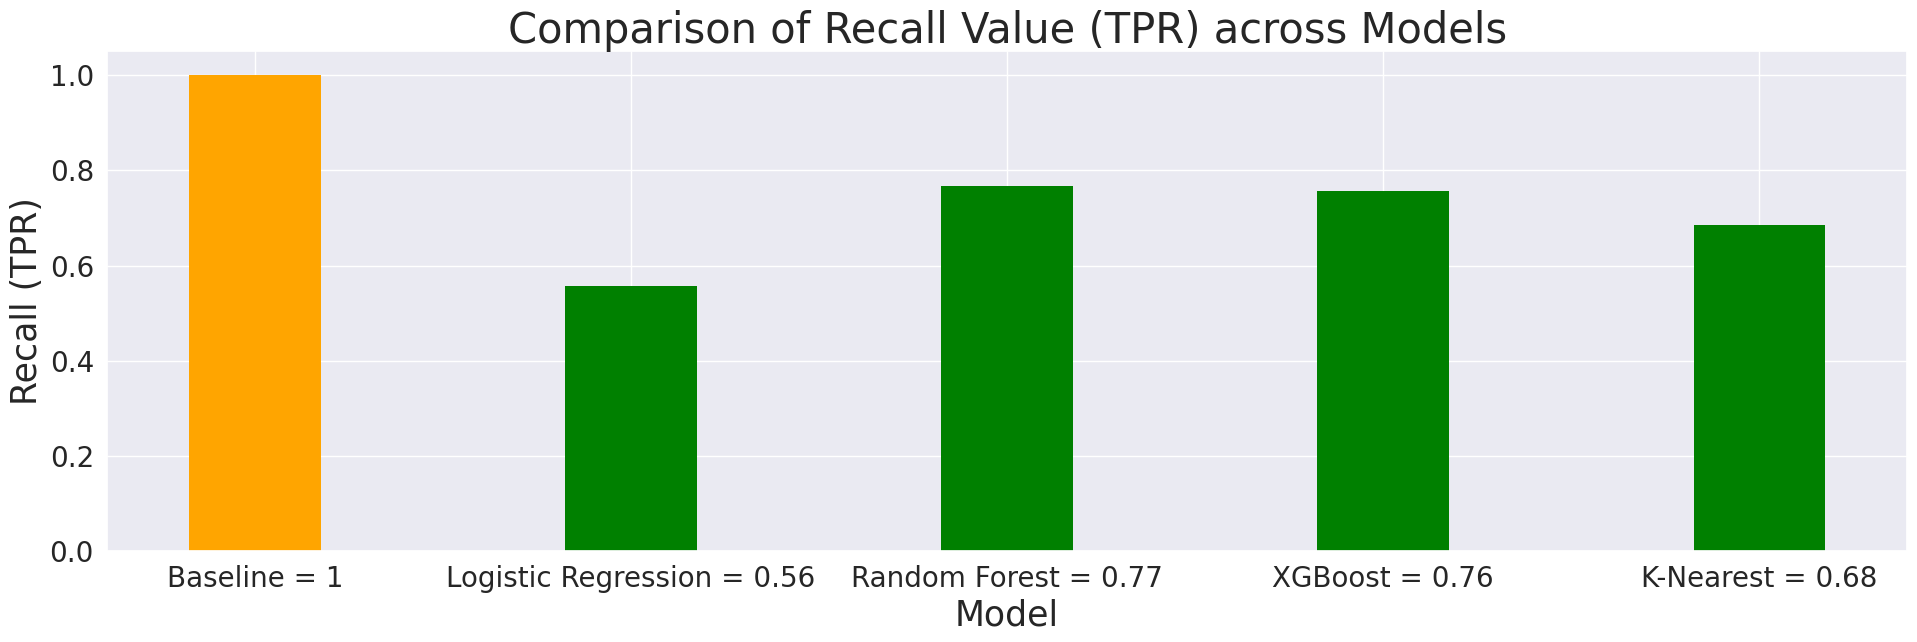

In [ ]:
fig = plt.figure(figsize=(18, 10))
fig.set_figheight(5)
fig.set_figwidth(18)
ax = fig.add_axes([0,0,1,1])
sns.reset_defaults()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(20)
models = ['Baseline = 1', f'Logistic Regression = {round(recall_log, 2)}', f'Random Forest = {round(recall_random, 2)}', f'XGBoost = {round(recall_xg, 2)}', f'K-Nearest = {round(recall_kn, 2)}']
recall = [1,recall_log,recall_random,recall_xg,recall_kn]
ax.bar(models, recall, width = 0.35, color = ['orange', 'green', 'green', 'green', 'green'])
plt.xlabel('Model', fontsize = 25)
plt.ylabel('Recall (TPR)', fontsize = 25)
plt.title('Comparison of Recall Value (TPR) across Models', fontsize = 30)
plt.show()

**Analysis:**
*   Even though the confusion matrices give us a big picture of TP, TN, FP, FN, we need to apply our domain knowledge to determine the metric that would be the most relevant when evaluating the models.

*   For instance, given a scenario where we use our models to issue credit card loans to users, does predicting a bad user as a good user expose the bank to more risks than predicting a good user as a bad user? 
  - By applying financial institutions' intuitions, we know that it's worse to issue a loan to a bad user that is predicted as a good user than to reject a loan to a good user that is predicted as a bad user. As a result, we think that it's the most appropriate to evaluate True Positive Rate (TPR), also known as the Recall value. This will allow us to add weights/importance to the false negatives and thus assess the number of false negatives across model.

*   Baseline Model: Note that since we predict all users as bad users, there's no false negatives. The model inherently yields a recall value of 1 because recall = TP / (TP + FN). In this case, it's impossible to beat the baseline model.

*   However, we still consider recall value a good metric to compare the performances across the four models. Among the four models, Randome Forest and XGBoost have the highest recall value, which implies that it has the lowest rate of false negatives and thus correctly flags bad users and minimizes the incorrect predictions of bad users as good users.

## Metric 4: F-1 Score

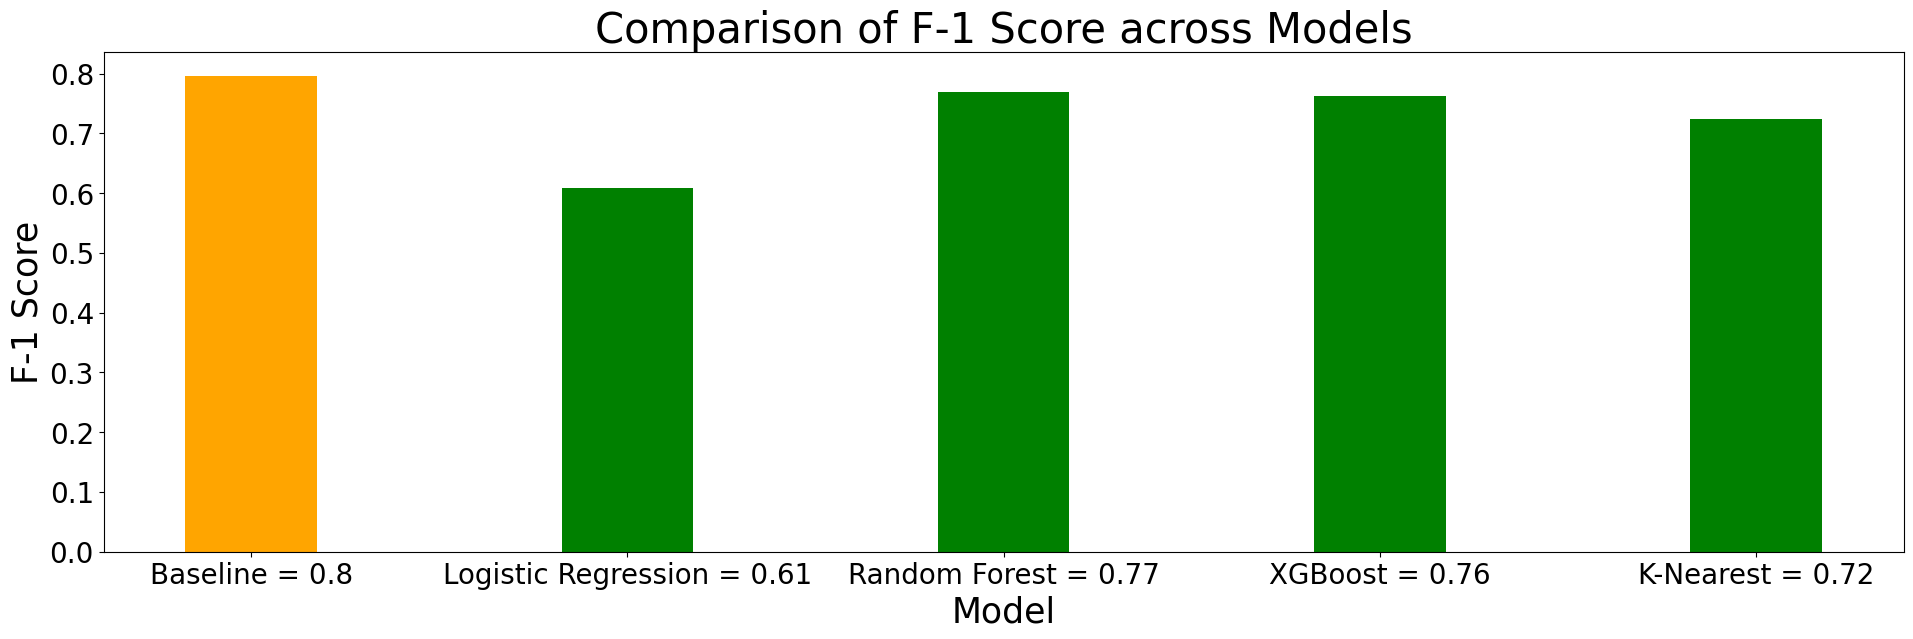

In [ ]:
fig = plt.figure(figsize=(18, 10))
fig.set_figheight(5)
fig.set_figwidth(18)
ax = fig.add_axes([0,0,1,1])
sns.reset_defaults()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(20)
models = [f'Baseline = {round(f1_base, 2)}', f'Logistic Regression = {round(f1_log, 2)}', f'Random Forest = {round(f1_random, 2)}', f'XGBoost = {round(f1_xg, 2)}', f'K-Nearest = {round(f1_kn, 2)}']
recall = [f1_base,f1_log,f1_random,f1_xg,f1_kn]
ax.bar(models, recall, width = 0.35, color = ['orange', 'green', 'green', 'green', 'green'])
plt.xlabel('Model', fontsize = 25)
plt.ylabel('F-1 Score', fontsize = 25)
plt.title('Comparison of F-1 Score across Models', fontsize = 30)
plt.show()

**Analysis:**

- F-1 Score is a harmonic mean of recall and precision. It is relatively difficult to maximize both precision and recall at the same time because there exists a trade-off between them.
- Note that our baseline model sacrifices precision for perfect recall. As a result, F-1 Score would be an appropriate metric when we compare our models to the baseline model since we take into account both recall and precision.  
- Now, amongst the four models, Random Forest and XGBoost have the highest F-1 scores as expected. To be specific, both of them have F-1 scores of approximately 0.77, which almost beat the baseline model's score of 0.8. This can be attributed to overfitting issues of our models. 
- K-Nearest Neighbor performed quite well on F-1 since it has a relatively high precision, whereas Logistic regression performed poorly, which is a phenomenon across all metrics.

# **6. Key Takeaways**

**Data**
* Our data is very imbalanced, so it is necessary to refine our target variables before feeding into our models. We chose to oversample the minority class using SMOTE, since we do not have sufficient data to do undersampling. By the design of our project, it is also not feasible to expand our training data.
* Our data contains a lot of categorical features which require encoding. There is a trade-off between one-hot encoding and label encoding. Label encoding is suitable for features that have ranking implications while one-hot encoding is suitable for features without ranking implications. However, if a feature has a lot of classes, one-hot encoding might yield too many predictors, leading to overfit issues.
* Our data has no target veriables ready to use, so we need to create an appropriate target variable for binary classification. This is the crucial part and usually requires domain knowledge. At first, our classfication method did not quite reflect the real-world scenario, leading to a very imbalanced class and poor performance of our models. We were able to identify this error after seeing 0.5 ROC scores, signifying a crucial error in the design of our model.
* Afterwards, we were able to capture and integrate the idea of credit scores into our feature engineering, which helped improve the overall model performance.

**Models**
* When tackling a testing data with imbalanced classes, the suggested baseline model is to always predict the majority class. This would create a threshold for our models to beat. However, if the data is very imbalanced, say, 99-1 distribution, it would be hard to beat the accuracy of baseline model. Resampling or sampling more data would help mitigate this problem.
* Our logistic regression performed badly on both training and testing data. The potential contributing factor might be that the target variables have no linear correlation with the features as we can see when we revisit data visualization in part 2.4.
* XGBoost and Random Forest are the best binary classification models since they have the highest test accuracies, AUC ROC scores, recall values, and F-1 scores. However, Gradient Boosting did not help improve the performance of our Random Forest, potentially due to the fact that our model was already overfitted.
* K-Nearest Neighbors model performed quite well on minimizing the amount of false positives but relatively poorly on minimizing false negatives. Thus, this model might not be the best fit for our problem.

**Metrics**
* In terms of metrics analysis, AUC ROC scores, recall values, and F-1 scores are all relevant metrics because they evaluate the models by adding weights to certain categories.
* It is necessary to use domain knowledge to determine the appropriate metric, for example, whether false negatives or false positives are more costly. In our case, recall should be prioritized before precision since capping false negatives (granting loans to bad credit users) is more crucial than capping false positives (rejecting loans to good credit users). 
* However, the commonly used test accuracy metric can be slightly misleading due to the imbalanced dataset at hand. We are able to combat this by finding other testing data that is less skewed, to be considered as a future recommendation!

# **7. Challenges Faced**
* Our data was not clean and contained a lot more categorical features than numeric features, which required significant amount of data preprocessing. 
* The binary target variables is not given as part of the data. As a result, we had to identify the definition of ‘good’ and ‘bad’ credit users by creating target variables. Initially, defining the target variables yielded severely imbalanced dataset and underfit problems, since our method did not reflect the real-world scenario. Thus, we revisited and redefined the target variables by leveraging the domain knowledge of how credit scores work in the real world, which helped improve our model performance and extreme data imbalance.
* Though slightly better, our data was still imbalanced after redefining target variables, which affected our model performance. Thus, we went back to fix the problem using SMOTE. By oversampling the minority class, we were able to mitigate the underfit problems.
* We found out that Gradient Boosting using XGBoost yielded similar performance as Random Forest. In theory, gradient boosting can result in better performance than random forests if parameters are carefully tuned. However, gradient boosting may not be the best choice if the dataset contains a lot of noise, as it can result in overfitting issues. We faced challenges in tuning the parameters in both Random Forest and XGBoost. We utilized Cross Validation and Grid Search to tune the parameters to tackle overfitting. 
* The two CV methods were able to slightly improve the performance of our model. However, given the constraint on processing and run time, we weren't able to test with a large set of parameters. The result was, to this effect, relatively limited.

# **8. Next Steps / Future Recommendations**
* After SMOTE, our Random Forest, XGBoost, and KNN models performed better but are seemingly overfit since the accuracy dropped a lot in test data. Our future direction is to find ways to tackle overfit beyond what we already did. For example,
  - Go back to feature engineering and refine feature selection.
  - Learn more about how to systematically tune parameters in these models.
  - Perform cross-validation on our models.
  - Train with more data (impractical). 
* Data Imbalance caused problems to our model, so sampling more data or resampling would be helpful in the improvement of our models.
* Since creating effective target variables requires domain knowledge, a future recommendation is to dive deep into the methods financial instutions determine risks of credit card users based on the payment data, and further apply these methods in our feature engineering.
* More models can be implemented in the future such as:
  - Feed-Forward Neural Network: help with learning complex features.
  - Unsupervised Learning (e.g. k-Means Clustering and Hierarchical Clustering): help classify customers into groups and possibly help determine whether there exists any clusters of customers that possess similar attributes or represent the same profile. This information would be helpful in determining whether these profiles contain indicative features for our predictions.
